# Проект "Маркетинг"

Краткое описание проекта 
1. Цель проекта
Разработка модели машинного обучения для предсказания вероятности покупки клиентами интернет-магазина в течение следующих 90 дней.

2. Основные задачи:
Анализ и предобработка данных о покупках и рекламных рассылках
Разработка и отбор значимых признаков
Создание и оптимизация модели классификации
Тестирование и валидация результатов
3. Используемые данные:
История покупок (apparel-purchases)
История рекламных рассылок (apparel-messages)
Целевой признак (apparel-target)
4. Пла
   н реализации:
Этап 1: Подготовка данных
Импорт и первичная обработка датасетов
Очистка от дубликатов и аномалий
Создание новых признаков (агрегаты, временные метки)
Масштабирова
ние и нормализация
Этап 2: Анализ данных
Исследование корреляций
Отбор наиболее информативных признаков
Работа с несбал
ансированным датасетом
Этап 3: Моделирование
Обучение моделей:
Случайные деревья
LиGM
CatB(ROC_AUC, Precision, Recall)
Подбор опти
мального порога классификации
Этап 4: Анализ результатов
Оценка производительности з6аков
Интерпретация результатов
5. Ожидаемые результаты:
Разработанная модель с ROC_AUC > 0.73
Определены ключевые факторы, влияющие на вероятность покупки
Создана система для прогнозирования поведения клиентов
Данный проект позволит оптимизировать маркетинговые кампании и эффективнее распределять ресурсы за счет точного предсказания потенциальных покупателей.

## 1. Общие настройки

### 1.1. Импорт библиотек

In [1]:
!pip install -U scikit-learn -q

In [2]:
!pip install catboost -q

In [3]:
!pip install lightgbm -q

In [4]:
!pip install shap -q

In [5]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import warnings
import math
import ast

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             RocCurveDisplay,
                             brier_score_loss)
from sklearn.calibration import CalibratedClassifierCV

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import shap

### 1.2. Константы и функции

In [6]:
TEST_SIZE = 0.25
RANDOM_STATE = 124

In [7]:
def my_read_csv(path,
                parse_dates,
                sep = ',',
                decimal = '.'):
    """Функция загрузки данных из файлов csv в DataFrame, с первичной визуальной проверкой
    
    Args:
        path - полный или краткий путь к файлу
        parse_dates - список колонок с датами для автоматического преобразования типа
        sep - разделитель в csv, по умолчанию ','
        decimal - разделитель вещественных чисел, по умолчанию '.'
    Returns:
        df - DataFrame с данными
    """
    full_path = f'https://code.s3.yandex.net{path}'
    
    if os.path.exists(path):
        df = pd.read_csv(path, parse_dates = parse_dates, sep = sep, decimal = decimal)
        display(df.head())
        display(df.shape)
        display(df.info())
        display(df.describe().T)
        return df
    elif os.path.exists(full_path):
        df = pd.read_csv(full_path, parse_dates = parse_dates, sep = sep, decimal = decimal)
        display(df.head())
        display(df.shape)
        display(df.info())
        display(df.describe().T)
        return df
    else:
        prinf('Не найден путь к файлу!')

In [8]:
def get_group_set(df, column):
    '''Функция группирует данные по столбцу и считает кол-во строк в каждой группе
    
    Args:
         df - DataFrame с выборкой
         column - название колонки с изучаемым признаком, по которому группируем
    Returns:
        grouped - DataFrame, сгруппированный по столбцу column, отсортированный по количеству строк
    
    '''
    grouped = (df
               .groupby(column, dropna = False)
               .size()
               .to_frame()
               .rename(columns = {0:'count'})
               .reset_index(drop = False)
               .sort_values(by = 'count', ascending = False)
               .reset_index(drop = True)
              )
    return grouped

In [9]:
def plot_and_pie(df, title, xlabel, ylabel, explode, patches = True, labelrotation=45, pie_limit = 0):
    """Функция рисует столбчатую диаграмму признака,  а также общий pie
    
    Args:
        df - DataFrame, сгруппированный по изучаемому признаку с заранее посчитанным кол-вом
        title - подпись графика и оси х
        xlabel - подпись по оси х
        ylabel - подпись по оси y
        explode - массив explode для пирожка
        patches - если False - то без подписей к барам
        labelrotation - направление подписей по оси х
        pie_limit - пороговый процент категории для отображения подписи на пирожке 
    """
    
    #фигура и расположение
    fig = plt.figure(figsize = (14,5))
    grid = gs.GridSpec(1, 2, width_ratios=[1.7, 1])
    fig.subplots_adjust(left=0.1, right=1)
    ax0 = fig.add_subplot(grid[0])
    ax1 = fig.add_subplot(grid[1])
    
    df = df.fillna('NaN')
    
    #столбчатая диаграмма
    barplot = sns.barplot(ax = ax0,
                 data = df,
                 x = df.columns[0],
                 y = df.columns[1],
                 dodge = False)
    ax0.set_title(title, fontsize = 15, color = 'SteelBlue')
    ax0.set_xlabel(xlabel, fontsize = 12)
    ax0.set_ylabel(ylabel, fontsize = 12)
    ax0.tick_params(axis='x', labelrotation = labelrotation)
    ax0.grid(True)

    
    #Добавляем подписи к барам
    if patches:
        for p in barplot.patches:
            barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     size=9, xytext = (0, 8), 
                     textcoords = 'offset points')
    
    #пирожок
    #значения меньше этого процента подписывать не будем
    def autopct_func(pct):
        return f'{pct:.1f}%' if pct > pie_limit else ''
    sum_ = df[df.columns[1]].sum()
    df['pct'] = df[df.columns[1]] * 100 / sum_
    labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)
    
    df.plot(ax = ax1,            
            y = df.columns[1],
            kind = 'pie', 
            labels = labels,
            figsize = (14, 5), 
            legend = False, 
            autopct = autopct_func,
            explode = explode, 
            fontsize = 12)
    ax1.set_title('Распределение в долях')
    ax1.set_xlabel(xlabel, fontsize = 12)
    ax1.set_ylabel('')
    plt.show();

In [10]:
def my_hist(df,  x, bins, title, xlabel, ylabel, xticks = None, hspace = 0.3, figsize = (14, 8), with_box = False):
    """Функция рисует гистограмму признака , а также boxplot
    
    Args:
        df - DataFrame с выборкой
        x - название колонки с изучаемым признаком
        bins - кол-во бинов
        title - подпись графика и оси х
        xlabel - подпись по оси х
        ylabel - подпись по оси y
        xticks - массив со значениями меток по оси х
        hspace - отступ после гистограммы
        figsize - размеры графика
    """
        
    #фигура и расположение
    fig = plt.figure(figsize = figsize)
    if with_box:
        grid = gs.GridSpec(2, 1, height_ratios=[3, 1])
        fig.subplots_adjust(hspace = hspace)
        ax0 = fig.add_subplot(grid[0])
        ax1 = fig.add_subplot(grid[1])
    else:
        grid = gs.GridSpec(1, 1)
        ax0 = fig.add_subplot(grid[0])
    
    
    #Гистограмма 
    sns.histplot(ax = ax0,
                 data = df,
                 x = x,
                 bins = bins,
                 alpha = 0.5)
    ax0.set_title(title, 
                  fontsize = 15, 
                  color = 'SteelBlue')
    ax0.set_xlabel(xlabel, 
                   fontsize = 12)
    ax0.set_ylabel(ylabel, fontsize = 12)
    if xticks is not None: ax0.set_xticks(xticks)
    ax0.grid(True)

    #Усатый ящик
    if with_box:
        df[x].plot(ax = ax1,
                   kind = 'box' , 
                   vert = False)
        ax1.set_xlabel(xlabel, 
                       fontsize = 12)
        if xticks is not None: ax1.set_xticks(xticks)
        ax1.set_yticks([])
    
    plt.show();

In [11]:
def my_plot(df, title, xlabel, ylabel, patches = True, labelrotation=45):
    """Функция рисует столбчатую диаграмму признака
    
    Args:
        df - DataFrame, сгруппированный по изучаемому признаку с заранее посчитанным кол-вом
        title - подпись графика и оси х
        xlabel - подпись по оси х
        ylabel - подпись по оси y
        explode - массив explode для пирожка
        patches - если False - то без подписей к барам
        labelrotation - направление подписей по оси х
    """
    
    #фигура и расположение
    fig = plt.figure(figsize = (14,5))
    grid = gs.GridSpec(1, 1)
    fig.subplots_adjust(left=0.1, right=1)
    ax0 = fig.add_subplot(grid[0])
    
    df = df.fillna('NaN')
    
    #столбчатая диаграмма
    barplot = sns.barplot(ax = ax0,
                 data = df,
                 x = df.columns[0],
                 y = df.columns[1],
                 dodge = False)
    ax0.set_title(title, fontsize = 15, color = 'SteelBlue')
    ax0.set_xlabel(xlabel, fontsize = 12)
    ax0.set_ylabel(ylabel, fontsize = 12)
    ax0.tick_params(axis='x', labelrotation = labelrotation)
    ax0.grid(True)

    
    #Добавляем подписи к барам
    if patches:
        for p in barplot.patches:
            barplot.annotate(format(p.get_height(), '.1f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     size=9, xytext = (0, 8), 
                     textcoords = 'offset points')
    
    plt.show();

In [12]:
# Оптимизация числовых типов данных
def optimize_memory_usage(dfc: pd.DataFrame, print_size: bool=True, to_int: bool = False) -> pd.DataFrame:
    '''
    Доработал полезную функцию под эту задачу
    Function optimizes memory usage in dataframe
    dfc: pd.DataFrame - data table
    print_size: bool - display of optimization results
    to_int - если True, то все числовые округляем и приводим к int
    return pd.DataFrame - amount of optimized memory
    '''
    df = dfc.copy()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2  
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            if to_int:
                df[column] = df[column].round().astype(int)
                column_type = df[column].dtypes
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [13]:
def my_stats(sr, context = None, q = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]):
    """Функция для построения удобной статистики, как в разрезе какого-то признака так и без него.
    Рассчитывает кол-во, диапазон значений, среднее, медиану, стандартное отклонение и квантили
    
    Args:
        sr - Series с данными, по которым считаем статистику
        context - Series с данными, содержащими контекст, в разрезе которого считается статистика
        q - какие квантили показываем
    """
    #подфункция для расчета среднеквадратичного отклонения
    def calculate_std(column):
        return np.std(column, ddof=1)
    
      
    #строим показатели статистики по всей выборке
    funcs = ['count', 'min', 'mean', 'median', 'max'] #какие метрики показываем
    stats = sr.to_frame().apply(funcs)
    stats.columns = ['total']
    std = sr.to_frame().apply(calculate_std).to_frame()
    std.columns = ['total']
    std.index = ['std']
    quants = sr.quantile(q).to_frame()
    quants.columns = ['total']
    result = pd.concat([stats, std, quants], axis = 0)
    #если был передан столбец с признаком, по которому делим выборку, то строим дополнительную статистику в разрезе признака 
    if context is None:
        context = pd.Series([], dtype=float)
    if not context.empty:
        context = context.fillna('Nan')
        values = context.unique()
        for i in values:
            stats = sr[context == i].to_frame().apply(funcs)
            stats.columns = [i]
            std = sr[context == i].to_frame().apply(calculate_std).to_frame()
            std.columns = [i]
            std.index = ['std']
            quants = sr[context == i].quantile(q).to_frame()
            quants.columns = [i]
            result[i]  = pd.concat([stats, std, quants], axis = 0)                   
    return result.T

In [14]:
def get_best_model(X_train,
                   y_train,
                   set_number,
                   model,
                   model_name,
                   param_grid_list,
                   column_purpose = 'target', 
                   random_state = RANDOM_STATE,
                   scoring='roc_auc'):
    
    """Функция подбирает лучшую модель и обучает ее. 
    На вход принимает только числовые отмасштабированные признаки.
    Отдает на выход итоговый словарь с лучшей моделью и ее параметрами.
    
    Args:
        X_train - DataFrame с обучающей выборкой
        y_train - Series с целевым признаком обучающей выборки
        set_number - номер выборки,
        model - модель передаваемая в Pipeline в качестве параметра 'models'
        model_name - имя модели
        param_grid_list - список параметров, передаваемый в GridSearchCV
        column_purpose - название колонки с целевым признаком
        random_state - число для генератора случайных чисел
        scoring - метрика, по которой определяется лучшая модель в GridSearchCV
    
    Return:
        Словарь со структурой {
        'Тип модели',
        'Модель',
        'Параметры модели',
        'ROC_AUC',
        'Время оптимизации, сек',
        'Время обучения, сек',
        'Время предсказания, сек'
        }
    
    """
    
    #итоговый pipeline
    pipe_final = Pipeline(
        [('models', model)
        ])
    
    #создаем класс оптимизатора
    param_search = GridSearchCV(pipe_final,
                                param_grid_list,
                                cv = 5, 
                                scoring = scoring, 
                                n_jobs = -1)
    
    start = time.time()
    param_search.fit(X_train, y_train)
    time_search = (time.time() - start)
    
    best_index = param_search.best_index_  
    time_fit = param_search.cv_results_['mean_fit_time'][best_index]  # Среднее время обучения
    time_predict = param_search.cv_results_['mean_score_time'][best_index]  # Среднее время предсказания

    print(f'Номер выборки: {set_number}')
    print(f'Время оптимизации: {time_search:.2f} сек')
    print(f'Время обучения: {time_fit:.2f} сек')
    print(f'Время предсказания: {time_predict:.2f} сек')
    print(f'Лучшие параметры: {param_search.best_params_}')
    print(f'Лучшая метрика: {param_search.best_score_:.3f}')
    print('')
    
    
    #отдаем итоговый словарь с лучшей моделью, ее параметрами и тестовыми предсказаниями
    result = {
        'Тип модели' : [model_name],
        'Номер выборки' : [set_number],
        'Модель' : [param_search.best_estimator_],
        'Параметры модели' : [param_search.best_params_],
        'ROC_AUC' : [round(param_search.best_score_, 3)],
        'Время оптимизации, сек' : [round(time_search, 2)],
        'Время обучения, сек' : [round(time_fit, 2)],
        'Время предсказания, сек' : [round(time_predict, 2)]
    }
    
    return  result

In [15]:
def my_scatters(df, x, y, hues, x_ticks = [], y_ticks = [], palette = ['Red', 'Blue'], alpha = 0.7, figsize = None):
    """Функция, которая построит диаграммы рассеяния в разрезе передаваемых признаков, 
    строит графики в разрезе нескольких категориальных признаков.
    
    Args:
        df - DataFrame с данными
        x - название колонки, которая будет отражаться на оси x
        y - название колонки, которая будет отражаться на оси y
        hues - список с категориальными переменными, в разрезе которых будут графики
        x_ticks - список с тиками по оси х
        y_ticks - список с тиками по оси y
        palette = ['Red', 'Blue'] - список цветов для обозначения категориальных признаков
        alpha - степень прозрачности точек
        figsize = None - можно задать свой размер фигуры 
    """
    
    #рассчитываем размеры графиков
    qty_cols = len(hues) #кол-во графиков
    strings = qty_cols // 2 + qty_cols % 2 #считаем кол-во осей по вертикали 
    figsize = (10, 5 * strings) if figsize == None else figsize
    
    #строим оси
    fig = plt.figure(figsize = figsize)
    grid = gs.GridSpec(strings, 2)
    fig.subplots_adjust(left=0.3, right=1.2) 
    ax = []
    for i in range(qty_cols):
        ax.append(fig.add_subplot(grid[i]))
        
    #строим диаграммы
    for i in range(qty_cols):
        sns.scatterplot(ax = ax[i], 
                        data = df, 
                        x = x, 
                        y = y, 
                        hue = hues[i],
                        palette = palette, 
                        alpha = alpha)
        ax[i].set_title(f'Зависимость {y} от {x} в разрезе {hues[i]}', fontsize = 10, color = 'SteelBlue')
        ax[i].set_xlabel(x, fontsize = 12)
        ax[i].set_ylabel(y, fontsize = 12)
        ax[i].set_xticks(x_ticks) 
        ax[i].set_yticks(y_ticks)
        ax[i].grid(True)
        if i % 2 == 0:
            ax[i].legend(bbox_to_anchor = (-0.15, 0.6), loc = 'upper right')
        else:
            ax[i].legend(bbox_to_anchor = (1.05, 0.6), loc = 'upper left')
    
    plt.show();

### 1.3. Импорт файлов и первичная обработка

In [16]:
current_directory = os.getcwd()
display(f"Текущая директория: {current_directory}")

'Текущая директория: C:\\Users\\egork\\workshop_2'

In [17]:
apparel_messages = my_read_csv('apparel-messages.csv',
                               parse_dates = ['date',
                                              'created_at'
                                             ]
                              ) 

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


(12739798, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

,count,mean,min,25%,50%,75%,max,std
bulk_campaign_id,12739798.0,11604.587587,548.0,8746.0,13516.0,14158.0,14657.0,3259.211131
client_id,12739798.0,1515915625574831616.0,1515915625468060928.0,1515915625489149440.0,1515915625503432192.0,1515915625591286272.0,1515915626010288640.0,326551798.15769
date,12739798,2023-06-05 02:46:08.357990400,2022-05-19 00:00:00,2022-12-19 00:00:00,2023-07-20 00:00:00,2023-11-21 00:00:00,2024-02-15 00:00:00,NaN
created_at,12739798,2023-06-05 13:58:11.168689408,2022-05-19 00:14:20,2022-12-19 12:46:30,2023-07-20 17:21:54,2023-11-21 18:13:05,2024-02-15 23:58:40,NaN


Тут все нормально

In [18]:
apparel_purchases = my_read_csv('apparel-purchases.csv',
                                parse_dates = ['date']
                               ) 

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


(202208, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

,count,mean,min,25%,50%,75%,max,std
client_id,202208.0,1515915625596210944.0,1515915625468060928.0,1515915625490081280.0,1515915625557177088.0,1515915625624391936.0,1515915626010443520.0,145951436.369225
quantity,202208.0,1.006483,1.0,1.0,1.0,1.0,30.0,0.184384
price,202208.0,1193.301516,1.0,352.0,987.0,1699.0,85499.0,1342.252664
date,202208,2023-03-17 02:49:35.739832064,2022-05-16 00:00:00,2022-11-12 00:00:00,2023-04-12 00:00:00,2023-07-03 00:00:00,2024-02-16 00:00:00,NaN


Тут тоже все хорошо

In [19]:
apparel_target = my_read_csv('apparel-target_binary.csv',
                             parse_dates = []
                            ) 

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


(49849, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,1.927822e-02,1.375025e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Тут тоже все норм

## 2. Анализ и обработка данных

### 2.1. Дата-сет с рассылками apparel_messages

In [20]:
apparel_messages[apparel_messages['message_id'] == '1515915625474219766-4439-628341212233a'].head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16


Видно, что ключ message_id составной. Ищем полные дубликаты

In [21]:
sum_dupl = apparel_messages.duplicated().sum()
count_rows = apparel_messages.shape[0]

In [22]:
display(f'Дубликатов: {sum_dupl} ({(sum_dupl / count_rows):.3%})')

'Дубликатов: 48610 (0.382%)'

Удаляем

In [23]:
count_rows_old = apparel_messages.shape[0]
display(f'Строк до: {count_rows_old}')
apparel_messages.drop_duplicates(ignore_index = True,
                                 inplace = True)
count_rows_new = apparel_messages.shape[0]
display(f'Строк после: {count_rows_new}')
display(f'Удалено {((count_rows_old - count_rows_new) / count_rows_old):.3%}')

'Строк до: 12739798'

'Строк после: 12691188'

'Удалено 0.382%'

#### Действие с сообщением event

In [24]:
group = get_group_set(apparel_messages, 'event')
group

,event,count
0,send,9058174
1,open,3052481
2,click,483326
3,purchase,62593
4,hard_bounce,19763
5,soft_bounce,10582
6,unsubscribe,2833
7,hbq_spam,823
8,complain,527
9,subscribe,85


C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


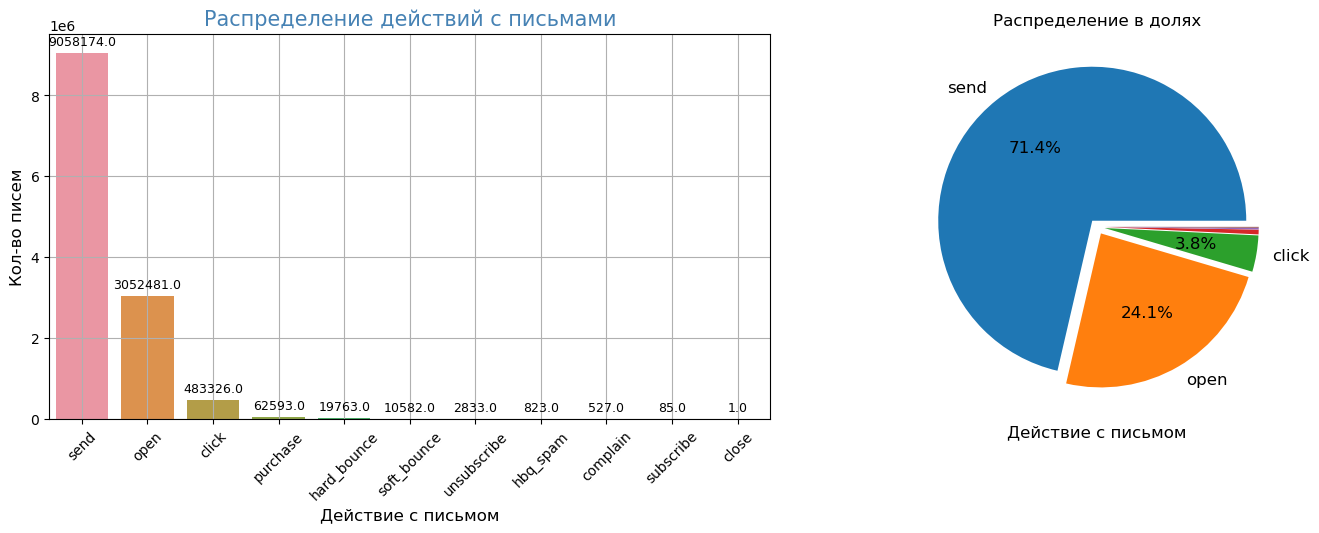

In [25]:
plot_and_pie(group, 
             title = 'Распределение действий с письмами',
             xlabel = 'Действие с письмом', 
             ylabel = 'Кол-во писем',
             explode = [0.05] * 11,
             pie_limit = 1)

Видим, что большинство статусов - это "Выслано". Вообще говоря, статус "Выслано" нас не должен интересовать, покупатель не видит сообщение пока не откроет его, так что этот статс не влияет на готовность совершить покупку в ближайшее время. Удалим строки с этим действием, иначе они будут искажать результат.

In [26]:
count_rows_old = apparel_messages.shape[0]
display(f'Строк до: {count_rows_old}')
apparel_messages = apparel_messages[apparel_messages['event'] != 'send']
count_rows_new = apparel_messages.shape[0]
display(f'Строк после: {count_rows_new}')
display(f'Удалено {((count_rows_old - count_rows_new) / count_rows_old):.3%}')

'Строк до: 12691188'

'Строк после: 3633014'

'Удалено 71.374%'

Освободили большую кучу памяти

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


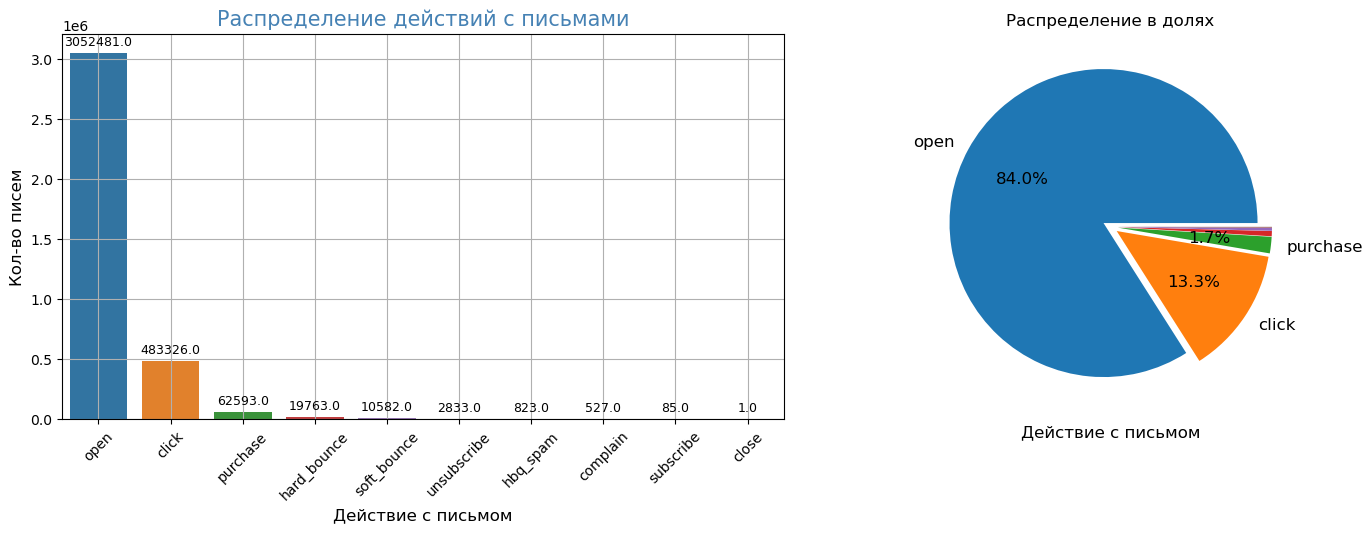

In [27]:
group = get_group_set(apparel_messages, 'event')
plot_and_pie(group, 
             title = 'Распределение действий с письмами',
             xlabel = 'Действие с письмом', 
             ylabel = 'Кол-во писем',
             explode = [0.05] * 10,
             pie_limit = 1)

Отправим категории численностью менее 20 тыс. в прочее

In [28]:
group

,event,count
0,open,3052481
1,click,483326
2,purchase,62593
3,hard_bounce,19763
4,soft_bounce,10582
5,unsubscribe,2833
6,hbq_spam,823
7,complain,527
8,subscribe,85
9,close,1


In [29]:
group['event_proc'] = group.apply(lambda row: row[0] if row[1] > 20000 else 'other', axis = 1)
mapping_dict = dict(zip(group['event'], group['event_proc']))
apparel_messages['event_proc'] = apparel_messages['event'].replace(mapping_dict)

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\1337099506.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group['event_proc'] = group.apply(lambda row: row[0] if row[1] > 20000 else 'other', axis = 1)


C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


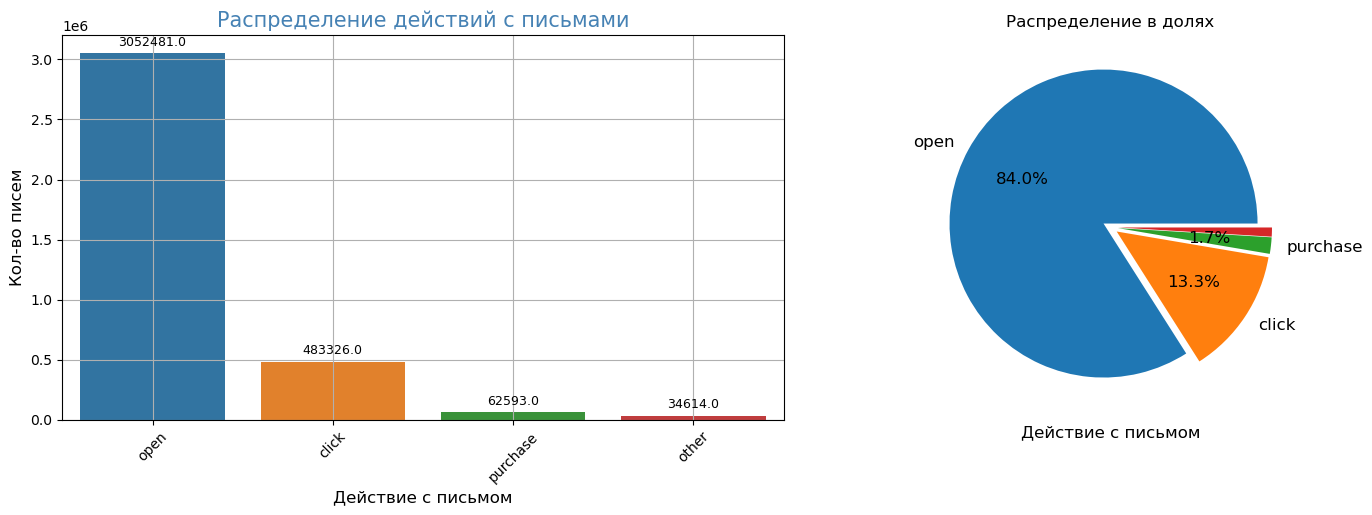

In [30]:
group = get_group_set(apparel_messages, 'event_proc')
plot_and_pie(group, 
             title = 'Распределение действий с письмами',
             xlabel = 'Действие с письмом', 
             ylabel = 'Кол-во писем',
             explode = [0.05] * 4,
             pie_limit = 1)

В итоге укрупнили категории, их осталось всего 4

#### Канал рассылки channel

In [31]:
group = get_group_set(apparel_messages, 'channel')
group

,channel,count
0,mobile_push,2349519
1,email,1283495


C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


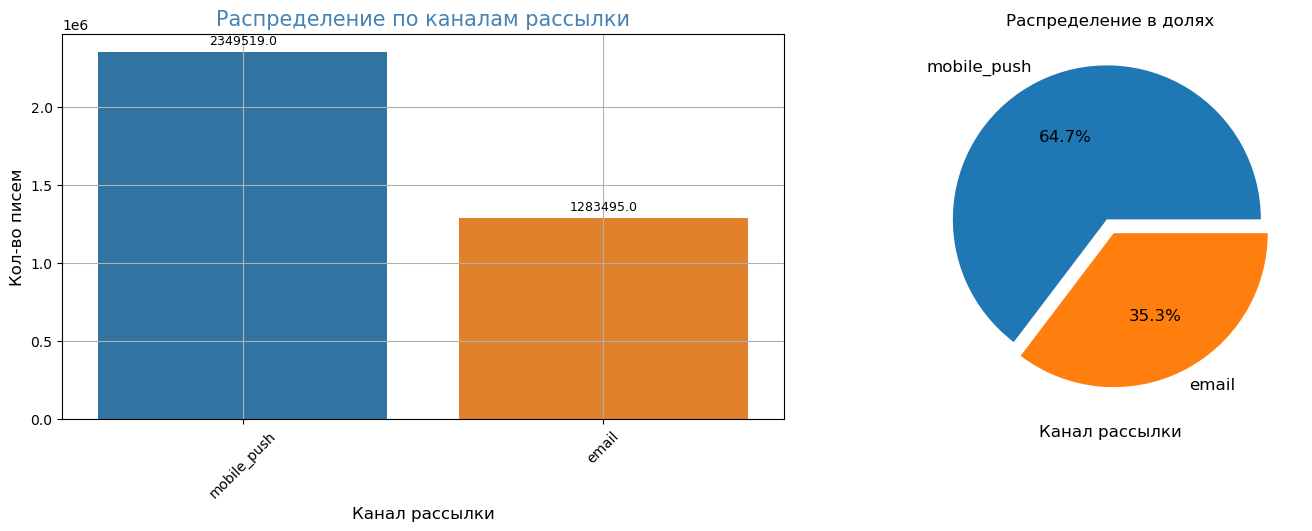

In [32]:
plot_and_pie(group, 
             title = 'Распределение по каналам рассылки',
             xlabel = 'Канал рассылки', 
             ylabel = 'Кол-во писем',
             explode = [0.05, 0.05])

Создаем консолидированный признак

In [33]:
apparel_messages['event_channel'] = apparel_messages['event'].str.cat(apparel_messages['channel'], sep='_')

In [34]:
group = get_group_set(apparel_messages, 'event_channel')
group

,event_channel,count
0,open_mobile_push,2179343
1,open_email,873138
2,click_email,351949
3,click_mobile_push,131377
4,purchase_email,44215
5,hard_bounce_mobile_push,19404
6,purchase_mobile_push,18378
7,soft_bounce_email,9566
8,unsubscribe_email,2833
9,soft_bounce_mobile_push,1016


Объединим категории с численностью меньше 20 тыс. в other

In [35]:
group['event_proc'] = group.apply(lambda row: row[0] if row[1] > 20000 else 'other', axis = 1)
mapping_dict = dict(zip(group['event_channel'], group['event_proc']))
apparel_messages['event_channel'] = apparel_messages['event_channel'].replace(mapping_dict)

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\751719024.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group['event_proc'] = group.apply(lambda row: row[0] if row[1] > 20000 else 'other', axis = 1)


C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


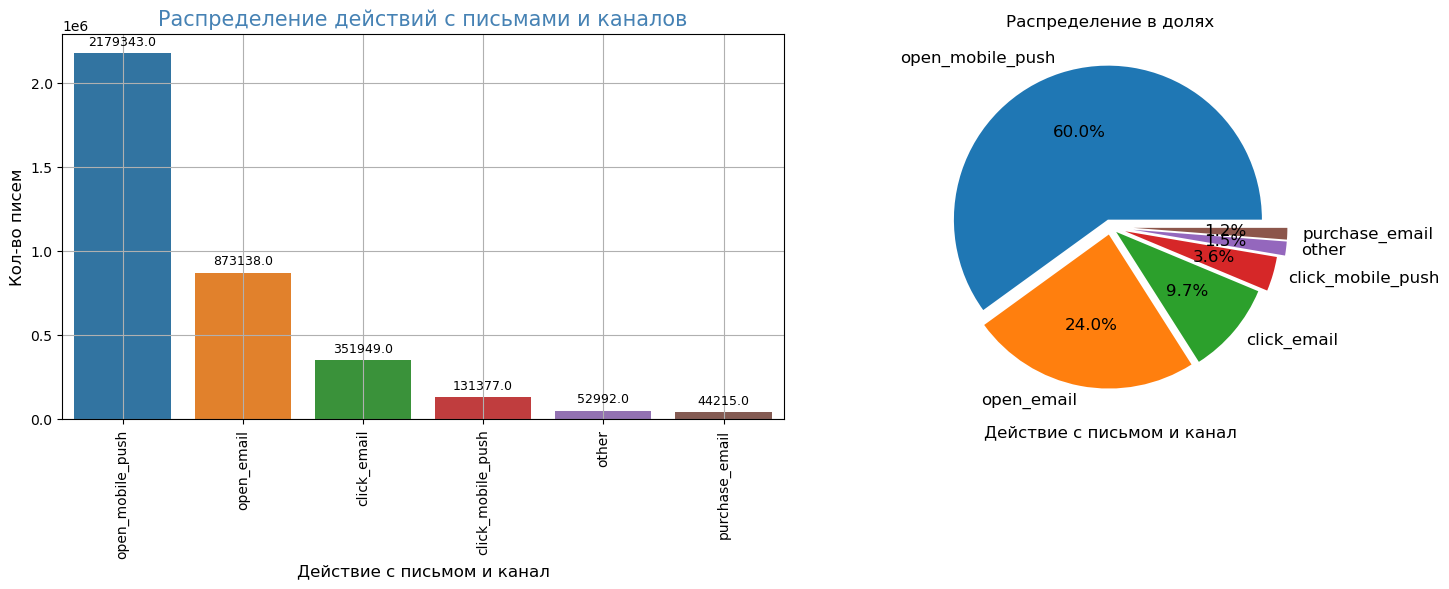

In [36]:
group = get_group_set(apparel_messages, 'event_channel')
plot_and_pie(group, 
             title = 'Распределение действий с письмами и каналов',
             xlabel = 'Действие с письмом и канал', 
             ylabel = 'Кол-во писем',
             labelrotation = 90,
             explode = [0.05] * 3 + [0.1] + [0.15] * 2,
             pie_limit = 1)

#### Дата действия date

In [37]:
date_min = apparel_messages['date'].min()
date_max = apparel_messages['date'].max()
display(f'Минимальная дата: {date_min.strftime("%Y-%m-%d")}')
display(f'Максимальная дата: {date_max.strftime("%Y-%m-%d")}')

'Минимальная дата: 2022-05-19'

'Максимальная дата: 2024-02-15'

C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


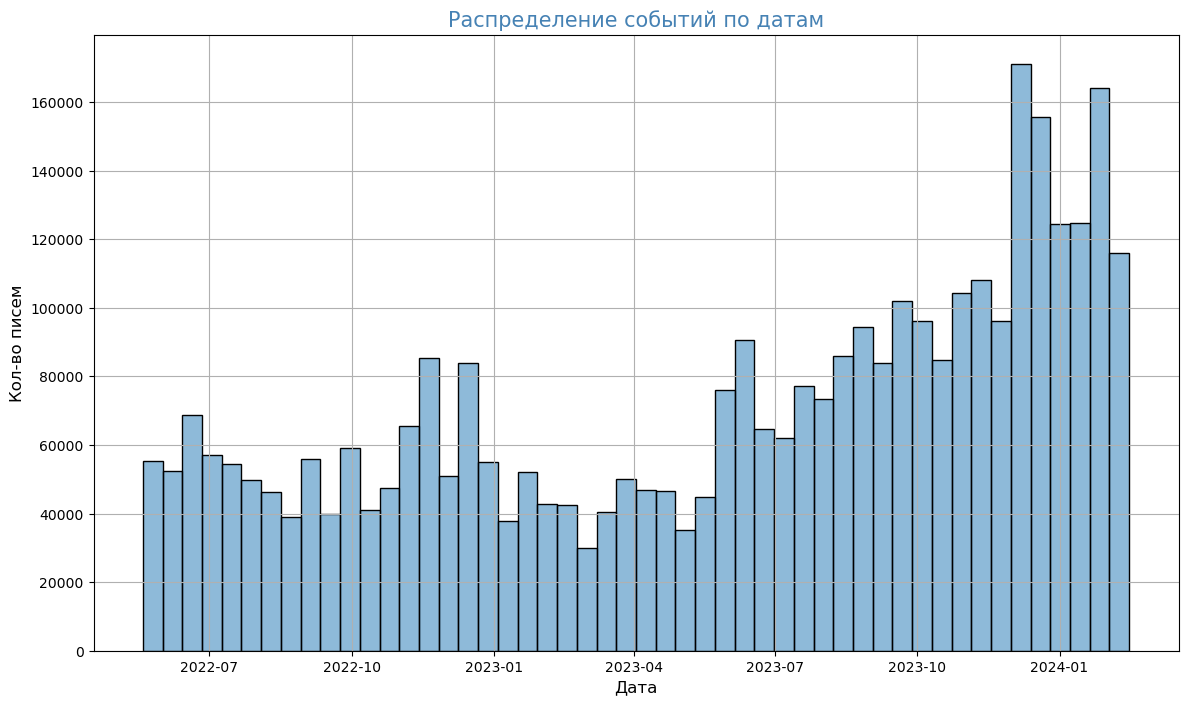

In [38]:
my_hist(apparel_messages,
        x = 'date', 
        bins = 50, 
        title = 'Распределение событий по датам', 
        xlabel = 'Дата',
        ylabel = 'Кол-во писем')

Попробуем сгруппировать до месяца 

In [39]:
apparel_messages['month'] = apparel_messages['date'].dt.to_period('M').dt.to_timestamp()

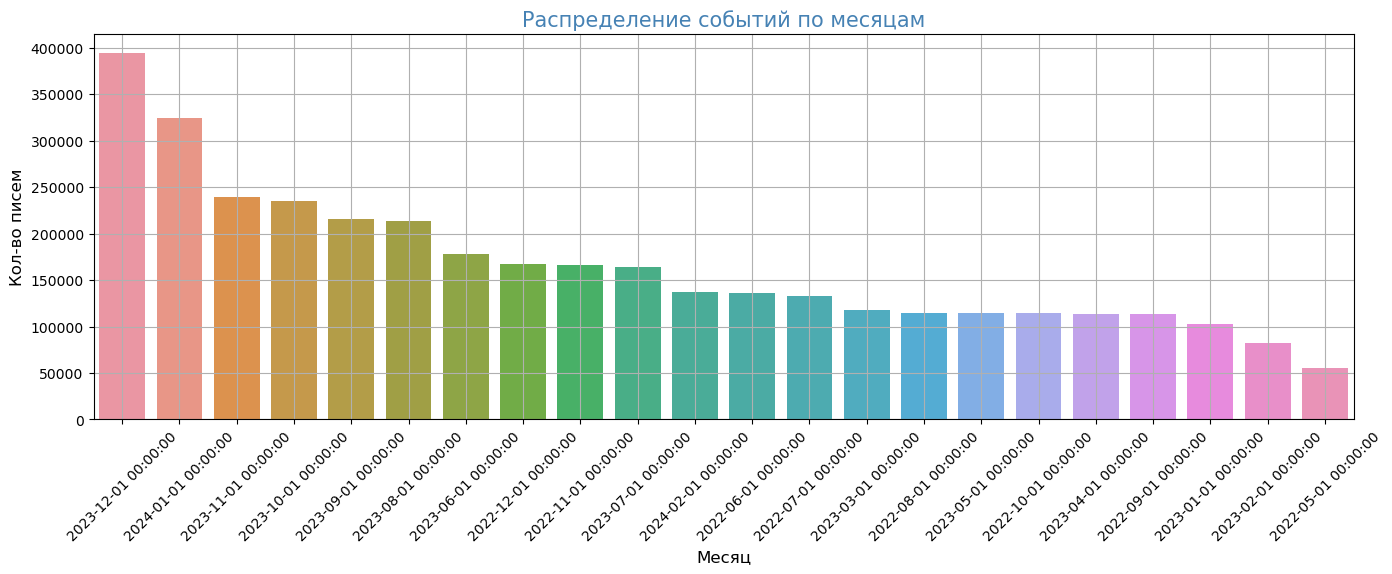

In [40]:
grouped = get_group_set(apparel_messages, 'month')

my_plot(grouped, 
        title  = 'Распределение событий по месяцам', 
        xlabel = 'Месяц',
        ylabel = 'Кол-во писем',
        patches = False)

А если до года

In [41]:
apparel_messages['year'] = apparel_messages['date'].dt.year

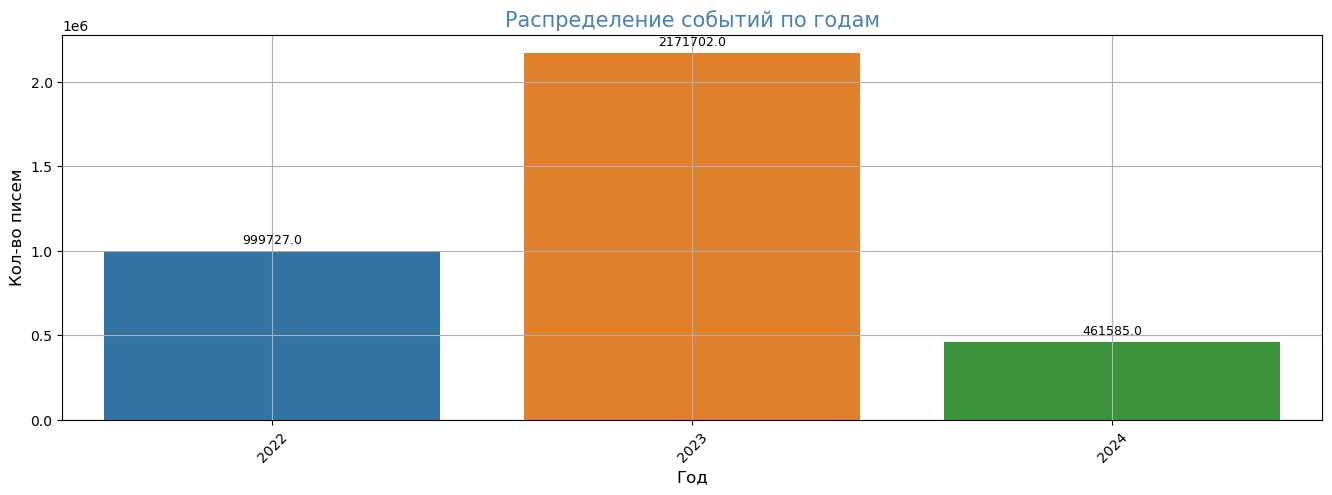

In [42]:
grouped = (get_group_set(apparel_messages, 'year')
          .reset_index(drop = True)
          .sort_values(by = 'year')
          )
my_plot(grouped, 
        title  = 'Распределение событий по годам', 
        xlabel = 'Год',
        ylabel = 'Кол-во писем')

In [43]:
apparel_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,event_proc,event_channel,month,year
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,open,open_email,2022-05-01,2022
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,open,open_email,2022-05-01,2022
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,open,open_email,2022-05-01,2022
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,click,click_email,2022-05-01,2022
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,open,open_email,2022-05-01,2022


#### Время действия created_at

Дату мы уже изучили, посмотрим на время суток

In [44]:
apparel_messages['hour'] = apparel_messages['created_at'].dt.hour

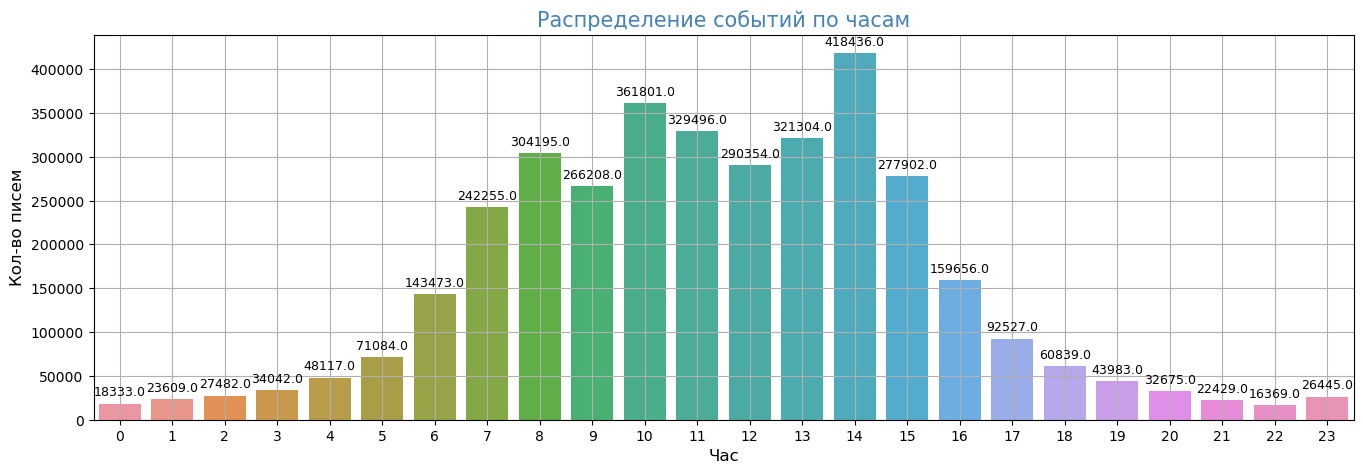

In [45]:
grouped = (get_group_set(apparel_messages, 'hour')
          .sort_values(by = 'hour')
          )
my_plot(grouped, 
        title  = 'Распределение событий по часам', 
        xlabel = 'Час',
        ylabel = 'Кол-во писем',
        patches = True,
        labelrotation = 0)

Попробуем еще сгрупировать

In [46]:
def get_time_of_day(hour):
    if hour <= 4: 
        return 'night'
    elif hour <= 8:
        return 'early'
    elif hour <= 11:
        return 'morning'
    elif hour <= 16:
        return 'day'
    else:
        return 'evening'

In [47]:
apparel_messages['time_of_day'] = apparel_messages['hour'].apply(get_time_of_day)

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


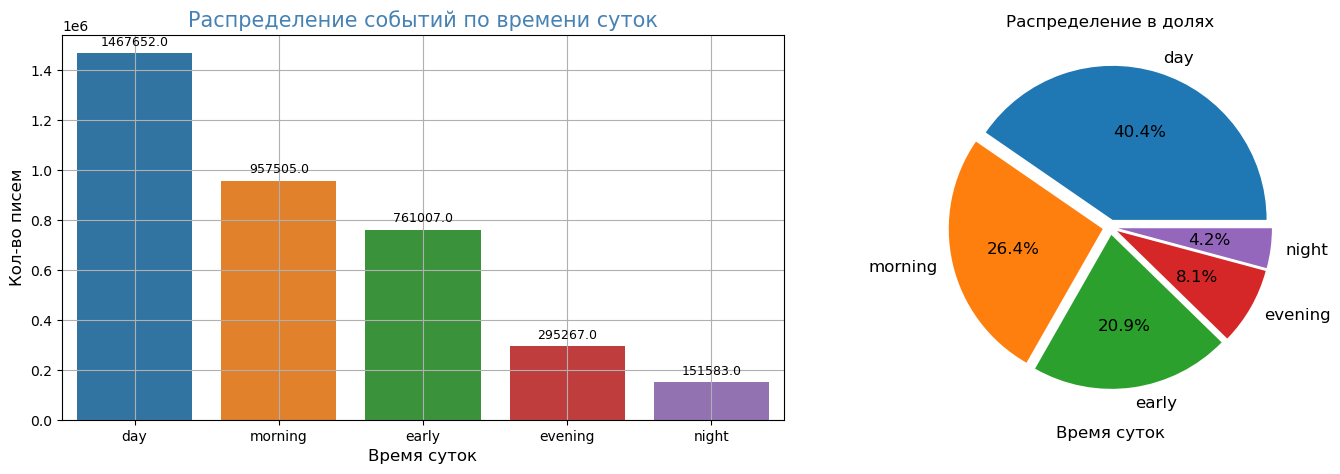

In [48]:
grouped = get_group_set(apparel_messages, 'time_of_day')

plot_and_pie(grouped, 
             title = 'Распределение событий по времени суток',
             xlabel = 'Время суток', 
             ylabel = 'Кол-во писем',
             labelrotation = 0,
             explode = [0.05] * 5)

#### Рекламная компания bulk_campaign_id

In [49]:
display(f'Кол-во рекламных компаний: {len(apparel_messages["bulk_campaign_id"].unique())}')

'Кол-во рекламных компаний: 2688'

Очень много, с этим признаком ловить нечего, был бы справочник рекламных компаний с какими-то атрибутами...  

#### Группировка таблицы по клиентам

Посмотрим что в разрезе клиентов

In [50]:
grouped = get_group_set(apparel_messages, 'client_id')
display(f"Кол-во клиентов: {grouped['client_id'].count()}")

'Кол-во клиентов: 52376'

In [51]:
my_stats(grouped['count'])

,count,min,mean,median,max,std,0.01,0.05,0.25,0.5,0.75,0.95,0.99
total,52376.0,1.0,69.364098,36.0,1444.0,78.427033,1.0,3.0,9.0,36.0,108.0,238.0,308.0


C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


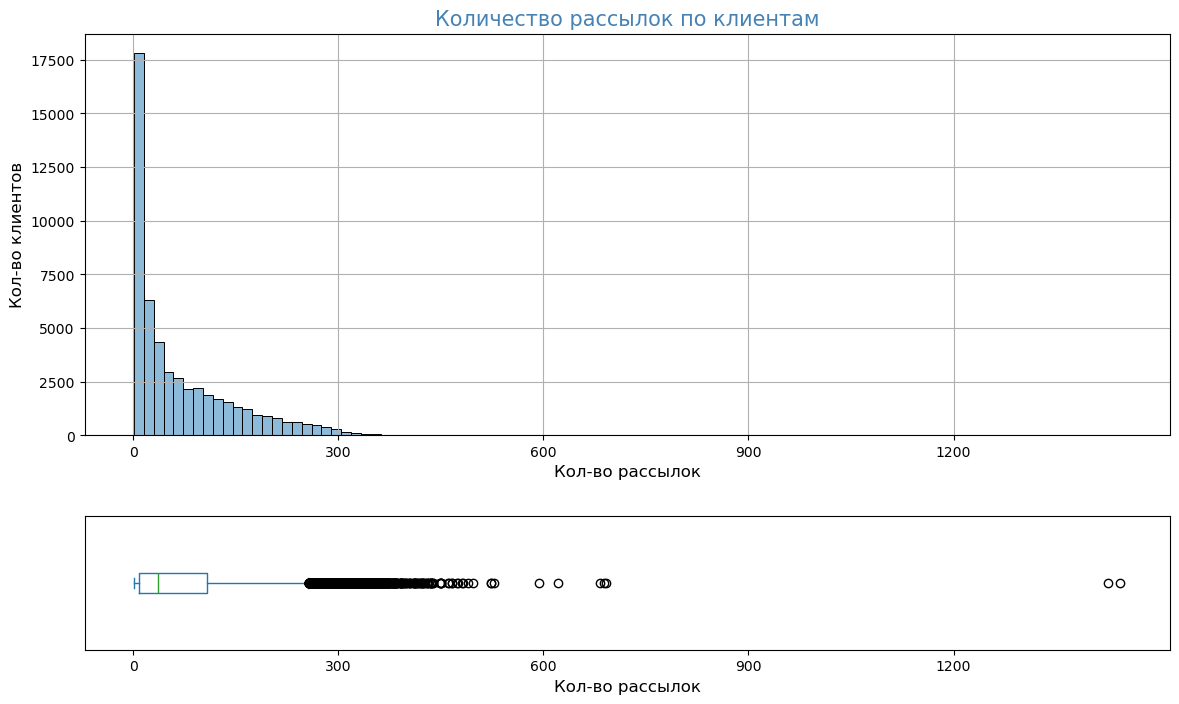

In [52]:
my_hist(grouped,
        x = 'count', 
        bins = 100, 
        title = 'Количество рассылок по клиентам', 
        xlabel = 'Кол-во рассылок',
        ylabel = 'Кол-во клиентов',
        xticks = np.arange(0, 1500, 300),
        with_box = True)

Есть небольшое кол-во выбросов

C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


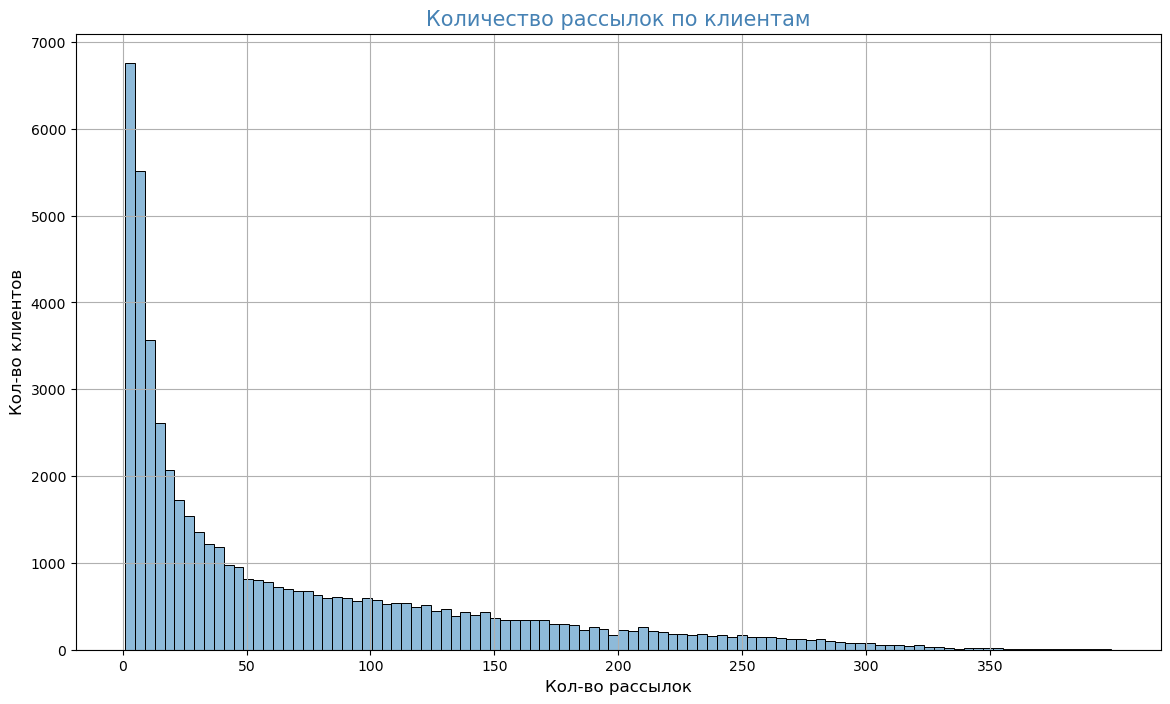

In [53]:
my_hist(grouped[grouped['count'] <= 400],
        x = 'count', 
        bins = 100, 
        title = 'Количество рассылок по клиентам', 
        xlabel = 'Кол-во рассылок',
        ylabel = 'Кол-во клиентов',
        xticks = np.arange(0, 400, 50))

Перейдем к инджинирингу признаков, собираем все нужные признаки в один. 

In [54]:
apparel_messages['final_feature'] = (apparel_messages['event_channel']
                                    .str.cat(apparel_messages['year'].astype(str), sep='_')
                                    .str.cat(apparel_messages['time_of_day'], sep='_')
                                   )

И собираем все в сводную таблиц, где в области строк будут клиенты, в области столбцов признаки, в области значений - кол-во действий клиента

In [55]:
apparel_messages_pivot = (apparel_messages
                          .pivot_table(index = 'client_id',
                                       columns = 'final_feature',
                                       values = ['message_id'],
                                       aggfunc = ['count'])
                          .fillna(0)
                         ) 
apparel_messages_pivot.columns = apparel_messages_pivot.columns.droplevel([0, 1])
apparel_messages_pivot.head()

final_feature,click_email_2022_day,click_email_2022_early,click_email_2022_evening,click_email_2022_morning,click_email_2022_night,click_email_2023_day,click_email_2023_early,click_email_2023_evening,click_email_2023_morning,click_email_2023_night,...,purchase_email_2023_day,purchase_email_2023_early,purchase_email_2023_evening,purchase_email_2023_morning,purchase_email_2023_night,purchase_email_2024_day,purchase_email_2024_early,purchase_email_2024_evening,purchase_email_2024_morning,purchase_email_2024_night
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,2.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061003,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061099,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061170,0.0,1.0,2.0,5.0,1.0,1.0,1.0,0.0,2.0,3.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
display(f'Количество признаков: {apparel_messages_pivot.shape[1]}')

'Количество признаков: 90'

В итоге получили 90 числовых признаков для клиентов, оптимизируем таблицу и отправляем в контейнер

In [57]:
apparel_messages_pivot = optimize_memory_usage(apparel_messages_pivot, to_int = True)

Размер использования памяти: до 36.36 Mb - после  5.44 Mb (85.0%)


In [58]:
apparel_messages_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52376 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   click_email_2022_day            52376 non-null  int16
 1   click_email_2022_early          52376 non-null  int8 
 2   click_email_2022_evening        52376 non-null  int16
 3   click_email_2022_morning        52376 non-null  int16
 4   click_email_2022_night          52376 non-null  int8 
 5   click_email_2023_day            52376 non-null  int16
 6   click_email_2023_early          52376 non-null  int8 
 7   click_email_2023_evening        52376 non-null  int8 
 8   click_email_2023_morning        52376 non-null  int8 
 9   click_email_2023_night          52376 non-null  int8 
 10  click_email_2024_day            52376 non-null  int8 
 11  click_email_2024_early          52376 non-null  int8 
 12  click_email_2024_evening        5

In [59]:
apparel_messages_pivot.head()

final_feature,click_email_2022_day,click_email_2022_early,click_email_2022_evening,click_email_2022_morning,click_email_2022_night,click_email_2023_day,click_email_2023_early,click_email_2023_evening,click_email_2023_morning,click_email_2023_night,...,purchase_email_2023_day,purchase_email_2023_early,purchase_email_2023_evening,purchase_email_2023_morning,purchase_email_2023_night,purchase_email_2024_day,purchase_email_2024_early,purchase_email_2024_evening,purchase_email_2024_morning,purchase_email_2024_night
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,2,2,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1515915625468061003,0,0,0,0,0,4,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1515915625468061099,2,1,1,1,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1515915625468061100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1515915625468061170,0,1,2,5,1,1,1,0,2,3,...,1,0,0,2,0,0,0,0,0,0


Алгоритм отработали, проверили, теперь пишем функцию и набираем несколько вариантов дата-сетов для обучения, будем использовать такие наборы признаков

In [61]:
features = [['event_channel', 'year', 'time_of_day'],
            ['event_channel', 'year'],
            ['event_channel'],
            ['event_proc']]
            

In [62]:
def get_apparel_messages_pivot(df, columns):
    cols = len(columns)
    for i, val in enumerate(columns):
        if i == 0:
            df['final_feature'] = df[val]
        else:
            df['final_feature'] = df['final_feature'].str.cat(df[val].astype(str), sep='_')
    df_pivot = (df
                .pivot_table(index = 'client_id',
                             columns = 'final_feature',
                             values = ['message_id'],
                             aggfunc = ['count'])
                .fillna(0)
               )  
    df_pivot.columns = df_pivot.columns.droplevel([0, 1])
    display(f'Количество признаков: {df_pivot.shape[1]}')
    df_pivot = optimize_memory_usage(df_pivot, to_int = True)
    df_pivot = df_pivot.reset_index().reset_index(drop = True)
    return df_pivot

In [63]:
apparel_messages_pivot_list = []

for i in features:
    pivot = get_apparel_messages_pivot(apparel_messages, i)
    apparel_messages_pivot_list.append(pivot)

'Количество признаков: 90'

Размер использования памяти: до 36.36 Mb - после  5.44 Mb (85.0%)


'Количество признаков: 18'

Размер использования памяти: до  7.59 Mb - после  1.80 Mb (76.3%)


'Количество признаков: 6'

Размер использования памяти: до  2.80 Mb - после  0.95 Mb (66.1%)


'Количество признаков: 4'

Размер использования памяти: до  2.00 Mb - после  0.75 Mb (62.5%)


In [64]:
apparel_messages_pivot_list[3].head()

final_feature,client_id,click,open,other,purchase
0,1515915625468060902,10,35,1,5
1,1515915625468061003,5,5,0,1
2,1515915625468061099,8,51,2,0
3,1515915625468061100,1,157,2,1
4,1515915625468061170,16,31,0,3


### 2.2. Дата-сет с покупками apparel_purchases

In [65]:
apparel_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [66]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


#### Дата покупки date

In [67]:
date_min = apparel_purchases['date'].min()
date_max = apparel_purchases['date'].max()
display(f'Минимальная дата: {date_min.strftime("%Y-%m-%d")}')
display(f'Максимальная дата: {date_max.strftime("%Y-%m-%d")}')

'Минимальная дата: 2022-05-16'

'Максимальная дата: 2024-02-16'

C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


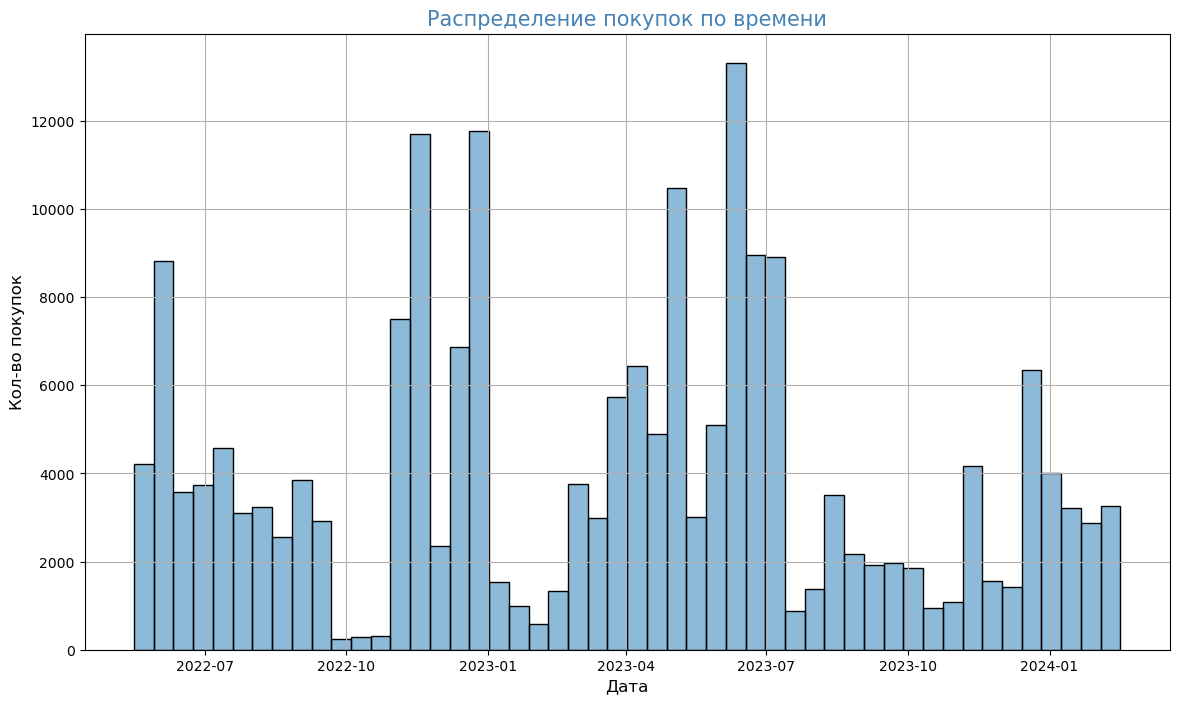

In [68]:
my_hist(apparel_purchases,
        x = 'date', 
        bins = 50, 
        title = 'Распределение покупок по времени', 
        xlabel = 'Дата',
        ylabel = 'Кол-во покупок')

Сгрппируем до месяца и года

In [69]:
apparel_purchases['month'] = apparel_purchases['date'].dt.to_period('M').dt.to_timestamp()

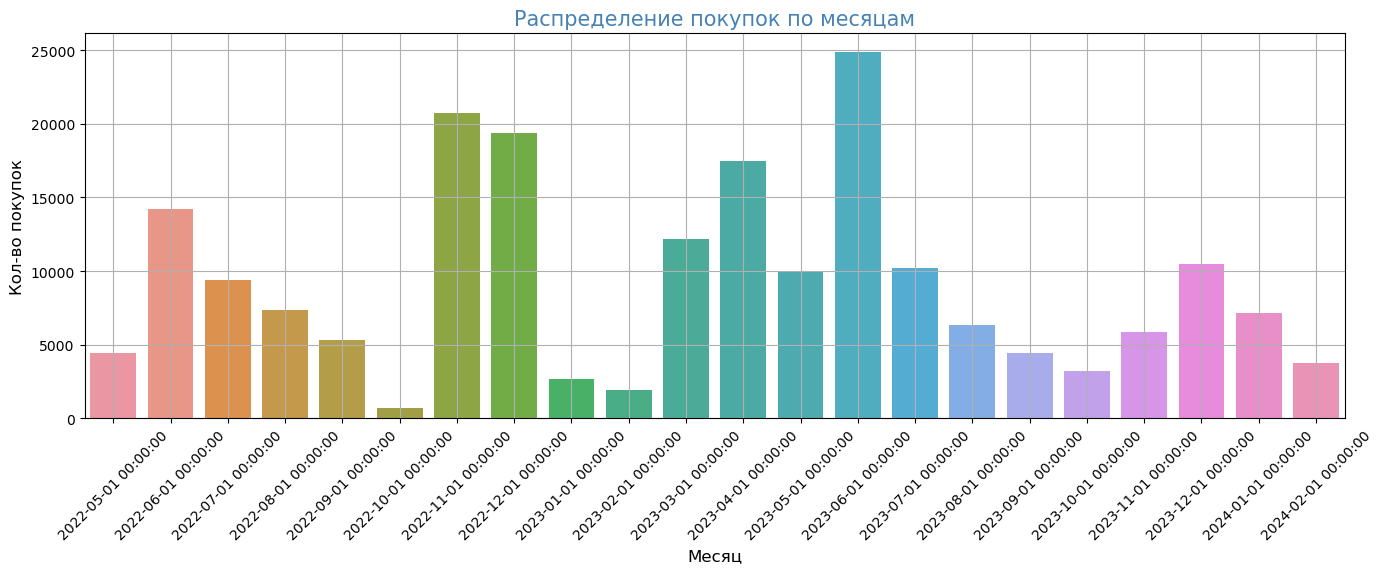

In [70]:
grouped = (get_group_set(apparel_purchases, 'month')
          .sort_values(by = 'month')
          )
my_plot(grouped, 
        title  = 'Распределение покупок по месяцам', 
        xlabel = 'Месяц',
        ylabel = 'Кол-во покупок',
        patches = False)

In [71]:
apparel_purchases['year'] = apparel_purchases['date'].dt.year

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


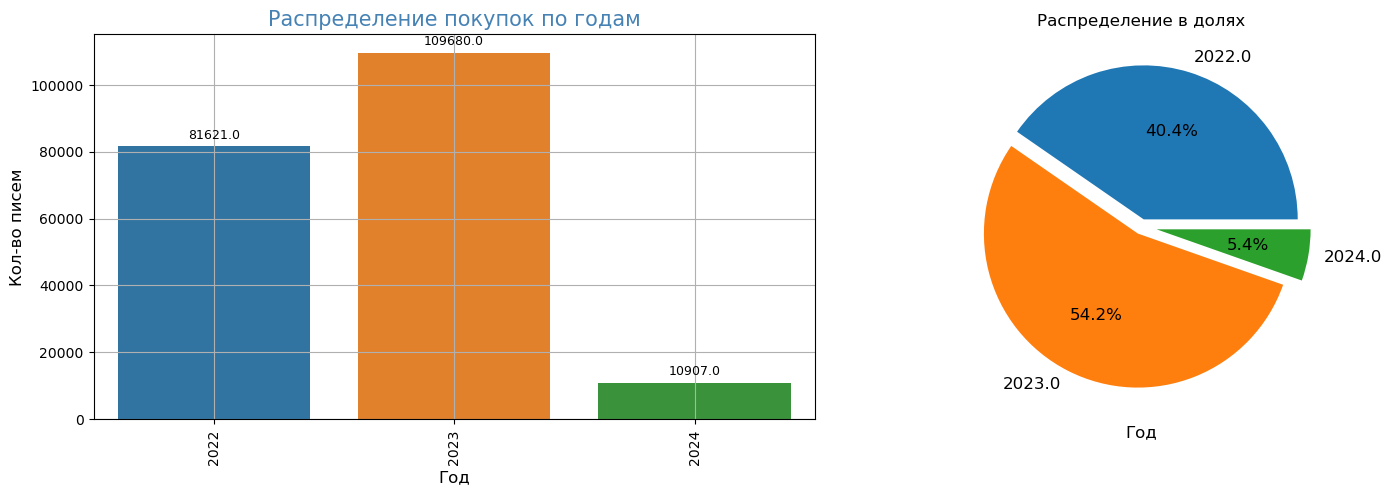

In [72]:
grouped = (get_group_set(apparel_purchases, 'year')
          .reset_index(drop = True)
          .sort_values(by = 'year')
          )

plot_and_pie(grouped, 
             title = 'Распределение покупок по годам',
             xlabel = 'Год', 
             ylabel = 'Кол-во писем',
             labelrotation = 90,
             explode = [0.05] * 2 + [0.1],
             pie_limit = 1)

#### Категории товара category_ids

In [73]:
apparel_purchases['category_ids'].unique()

array(["['4', '28', '57', '431']", "['4', '28', '244', '432']",
       "['4', '28', '49', '413']", "['2', '18', '258', '441']",
       "['2', '18', '341', '1311']", "['2', '18', '123', '451']",
       "['5562', '5631', '5549', '667']",
       "['5562', '5630', '5649', '678']", "['4', '27', '350', '1392']",
       "['4', '28', '44', '490']", "['2', '18', '267', '443']",
       "['4', '28', '213', '417']", "['5562', '5589', '5584', '1786']",
       "['5562', '5589', '5584', '1795']",
       "['5562', '5630', '5699', '550']",
       "['5562', '5634', '5579', '710']",
       "['5562', '5634', '5568', '957']",
       "['5562', '5634', '5693', '636']", "['2', '18', '344', '445']",
       "['4', '27', '353', '840']", "['4', '28', '343', '425']",
       "['4', '31', '326', '505']", "['4', '28', '260', '420']",
       "['5562', '5631', '5622', '560']",
       "['5562', '5631', '5549', '608']", "['4', '28', '290', '424']",
       "['2', '18', '212', '658']", "['4', '27', '142', '496']",
       "

In [74]:
display(f'Количество категорий: {len(apparel_purchases["category_ids"].unique())}')

'Количество категорий: 933'

Категорий очень много, посмотрим на группы категорий, похоже это первый элемент в списке

In [75]:
def fillna_list(lst):
    #заполняем пропуски в категориях и удлинняем иерархию если надо
    lst = [0 if x is None else x for x in lst]
    if len(lst) == 0: lst.append(0) 
    if len(lst) == 1: lst.append(0) 
    return lst

apparel_purchases['category_ids_list'] = apparel_purchases['category_ids'].apply(lambda x: ast.literal_eval(x))
apparel_purchases['category_ids_list'] = apparel_purchases['category_ids_list'].apply(fillna_list) 

In [76]:
apparel_purchases['category_group_id'] = (apparel_purchases['category_ids_list'].str[0].astype(str)
                                         .str.cat(apparel_purchases['category_ids_list'].str[1].astype(str), sep='_')
                                         )

In [77]:
apparel_purchases['category_group_id'].unique()

array(['4_28', '2_18', '5562_5631', '5562_5630', '4_27', '5562_5589',
       '5562_5634', '4_31', '4_1822', '4_5837', '2_17', '5562_5683',
       '4_29', '5562_5536', '5562_5597', '5562_5633', '5562_5599',
       '5562_5632', '5562_5558', '4_30', '1_8', '5562_5697', '0_0',
       '1_22', '5963_5959', '3_14', '4_44', '6060_6058', '6060_6059',
       '6060_6057', '5_10', '3_12'], dtype=object)

In [78]:
display(f'Количество групп категорий: {len(apparel_purchases["category_group_id"].unique())}')

'Количество групп категорий: 32'

Это уже приемлемо

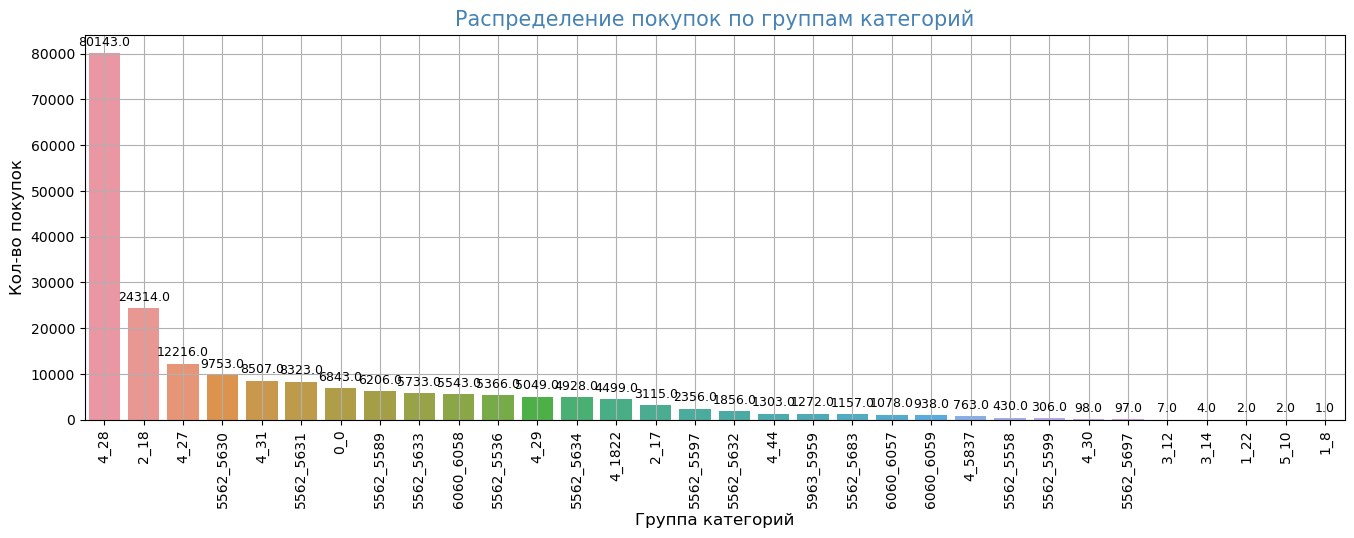

In [79]:
grouped = get_group_set(apparel_purchases, 'category_group_id')

my_plot(grouped, 
        title  = 'Распределение покупок по группам категорий', 
        xlabel = 'Группа категорий',
        ylabel = 'Кол-во покупок',
        patches = True,
        labelrotation = 90
       )

Избавимся от мелких категорий

In [80]:
grouped['category_group_id_proc'] = grouped.apply(lambda row: row[0] if row[1] > 1000 else '0_0', axis = 1)
mapping_dict = dict(zip(grouped['category_group_id'], grouped['category_group_id_proc']))
apparel_purchases['category_group_id'] = apparel_purchases['category_group_id'].replace(mapping_dict)

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\1013558346.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped['category_group_id_proc'] = grouped.apply(lambda row: row[0] if row[1] > 1000 else '0_0', axis = 1)


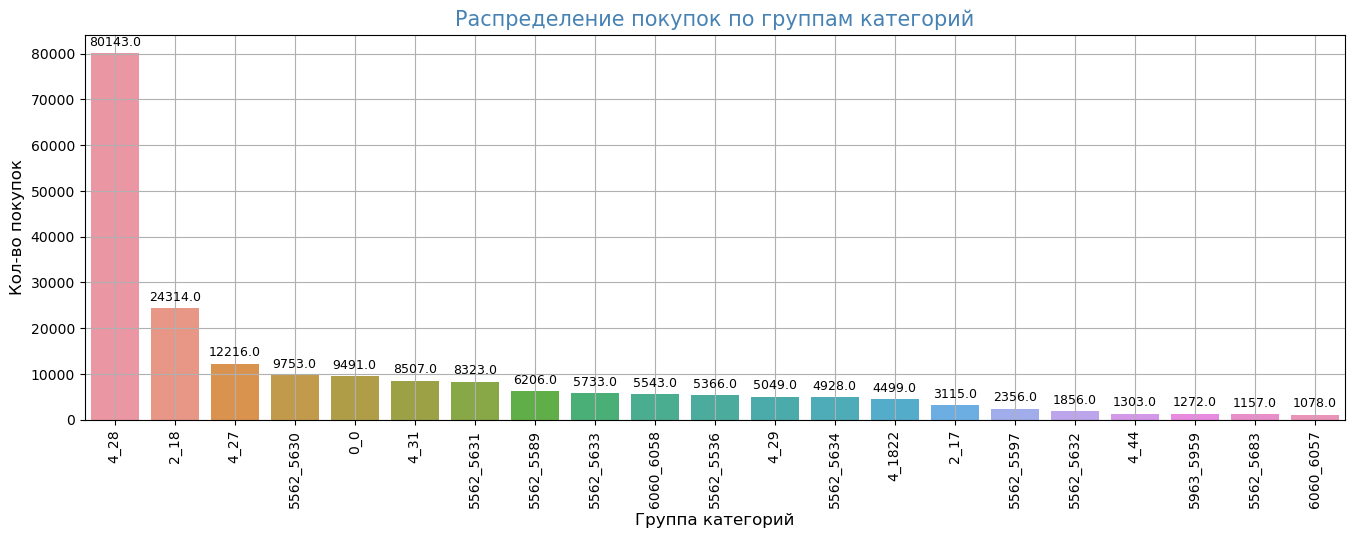

In [81]:
grouped = get_group_set(apparel_purchases, 'category_group_id')

my_plot(grouped, 
        title  = 'Распределение покупок по группам категорий', 
        xlabel = 'Группа категорий',
        ylabel = 'Кол-во покупок',
        patches = True,
        labelrotation = 90
       )

И более крупная группировка

In [82]:
apparel_purchases['category_group_id_light'] = apparel_purchases['category_ids_list'].str[0].astype(str)
display(f'Количество групп категорий: {len(apparel_purchases["category_group_id_light"].unique())}')
grouped = get_group_set(apparel_purchases, 'category_group_id_light')
grouped['category_group_id_proc'] = grouped.apply(lambda row: row[0] if row[1] > 1000 else '0', axis = 1)
mapping_dict = dict(zip(grouped['category_group_id_light'], grouped['category_group_id_proc']))
apparel_purchases['category_group_id_light'] = apparel_purchases['category_group_id_light'].replace(mapping_dict)

'Количество групп категорий: 9'

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\2131940898.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped['category_group_id_proc'] = grouped.apply(lambda row: row[0] if row[1] > 1000 else '0', axis = 1)


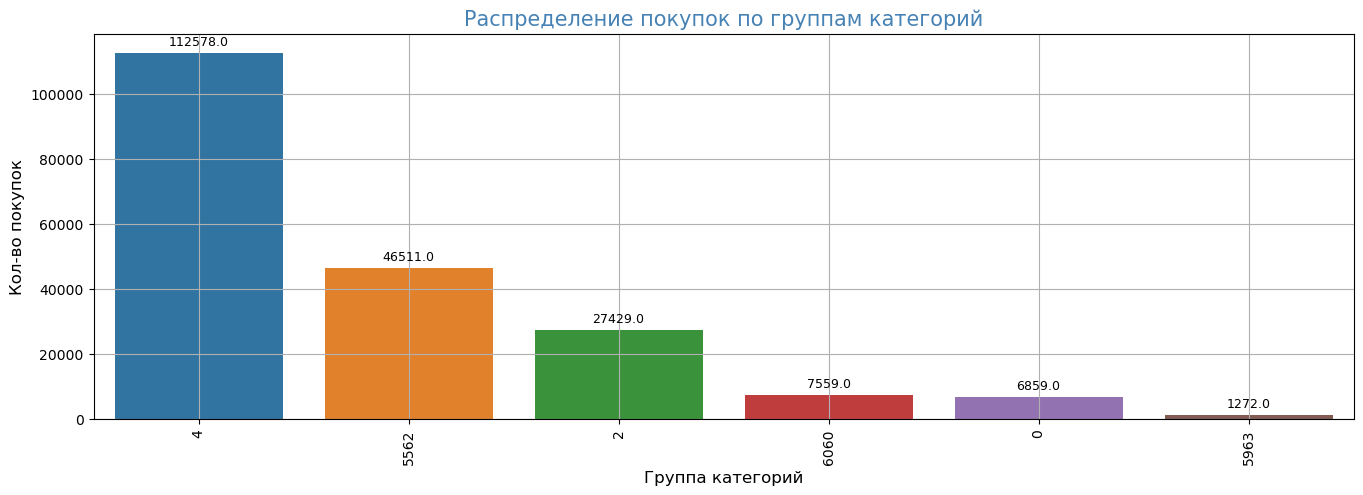

In [83]:
grouped = get_group_set(apparel_purchases, 'category_group_id_light')

my_plot(grouped, 
        title  = 'Распределение покупок по группам категорий', 
        xlabel = 'Группа категорий',
        ylabel = 'Кол-во покупок',
        patches = True,
        labelrotation = 90
       )

#### Количество в заказе quantity 

In [84]:
my_stats(apparel_purchases['quantity'])

,count,min,mean,median,max,std,0.01,0.05,0.25,0.5,0.75,0.95,0.99
total,202208.0,1.0,1.006483,1.0,30.0,0.184384,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [85]:
display(f'Кол-во строк с несколькими штуками: {apparel_purchases.loc[apparel_purchases["quantity"] > 1, "quantity"].count()}')

'Кол-во строк с несколькими штуками: 885'

В подавляющем большинстве строка в apparel_purchases - это купленная штука

#### Цена товара price

In [86]:
my_stats(apparel_purchases['price'])

,count,min,mean,median,max,std,0.01,0.05,0.25,0.5,0.75,0.95,0.99
total,202208.0,1.0,1193.301516,987.0,85499.0,1342.252664,3.0,27.0,352.0,987.0,1699.0,3199.0,5499.0


#### Сумма покупки

In [87]:
apparel_purchases['sum'] = apparel_purchases['quantity'] * apparel_purchases['price'] 

In [88]:
my_stats(apparel_purchases['sum'])

,count,min,mean,median,max,std,0.01,0.05,0.25,0.5,0.75,0.95,0.99
total,202208.0,1.0,1199.480288,997.0,85499.0,1355.024588,3.0,27.0,355.0,997.0,1699.0,3231.0,5499.0


C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


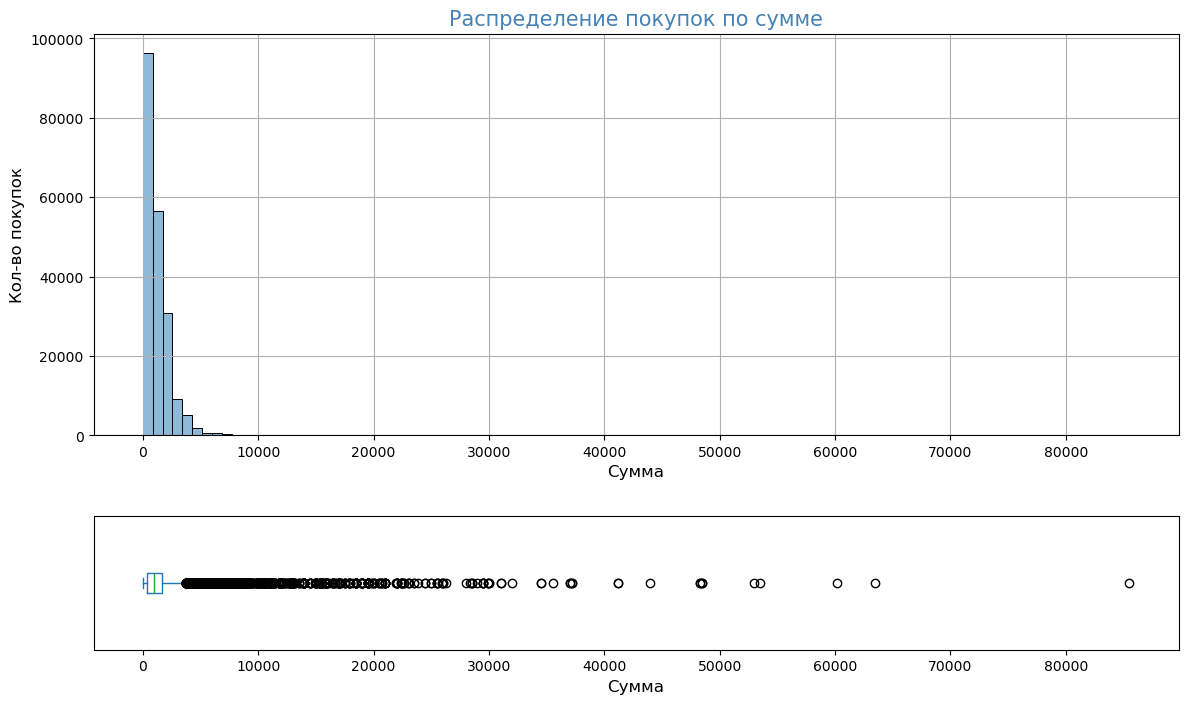

In [89]:
my_hist(apparel_purchases,
        x = 'sum', 
        bins = 100, 
        title = 'Распределение покупок по сумме', 
        xlabel = 'Сумма',
        ylabel = 'Кол-во покупок',
        xticks = np.arange(0, 90000, 10000),
        with_box = True)

C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


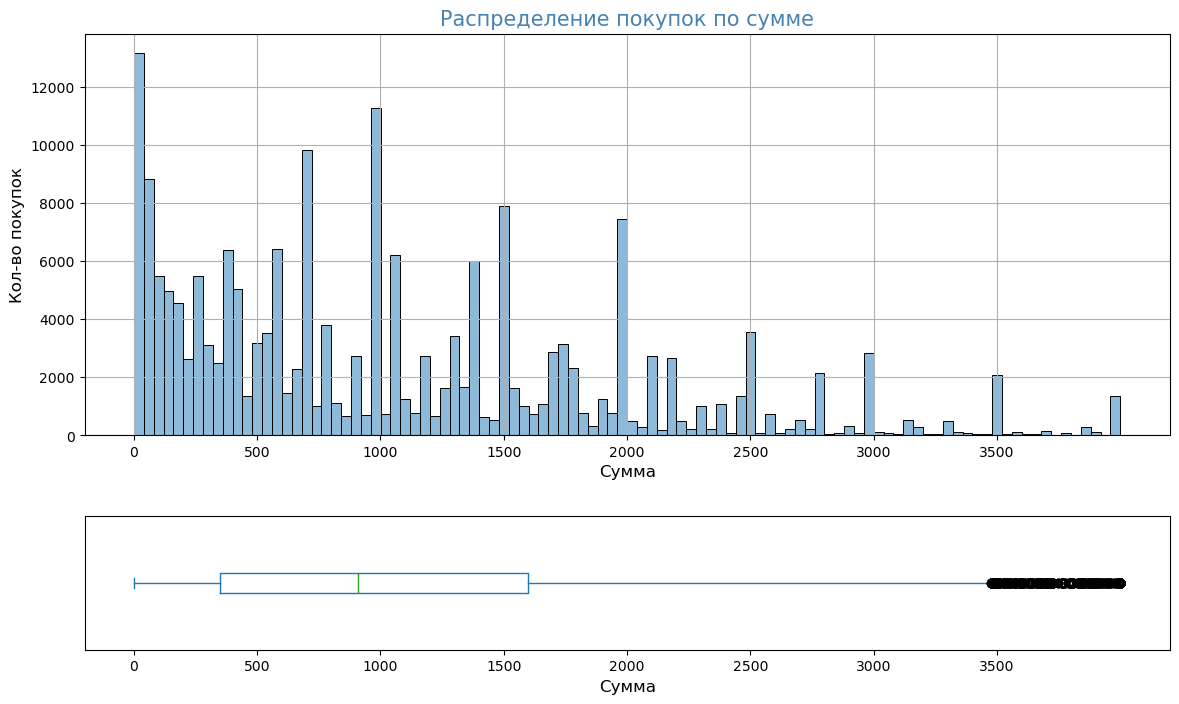

In [90]:
my_hist(apparel_purchases[apparel_purchases['sum'] <= 4000],
        x = 'sum', 
        bins = 100, 
        title = 'Распределение покупок по сумме', 
        xlabel = 'Сумма',
        ylabel = 'Кол-во покупок',
        xticks = np.arange(0, 4000, 500),
        with_box = True)

Преобладают покупки недорогих товаров, как и на любом обычном розничном маркетплейсе. Но также имеются покупки и дорогих товаров (на озоне вон даже авто теперь можно преобрести). Это создает выбросы для этого показателя, нужно учесть это в будущем.

#### Группировка таблицы по клиентам

Тут также создадим косолидированный признак, а потом несолько вариантов сводных таблиц. Причем считать будем один из двух показателей:

* Штук куплено
* Сумма куплено

In [91]:
grouped = apparel_purchases.groupby('client_id')[['quantity', 'sum']].sum()
my_stats(grouped['quantity'])

,count,min,mean,median,max,std,0.01,0.05,0.25,0.5,0.75,0.95,0.99
total,49849.0,1.0,4.08271,2.0,355.0,5.562927,1.0,1.0,1.0,2.0,5.0,12.0,25.0


C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


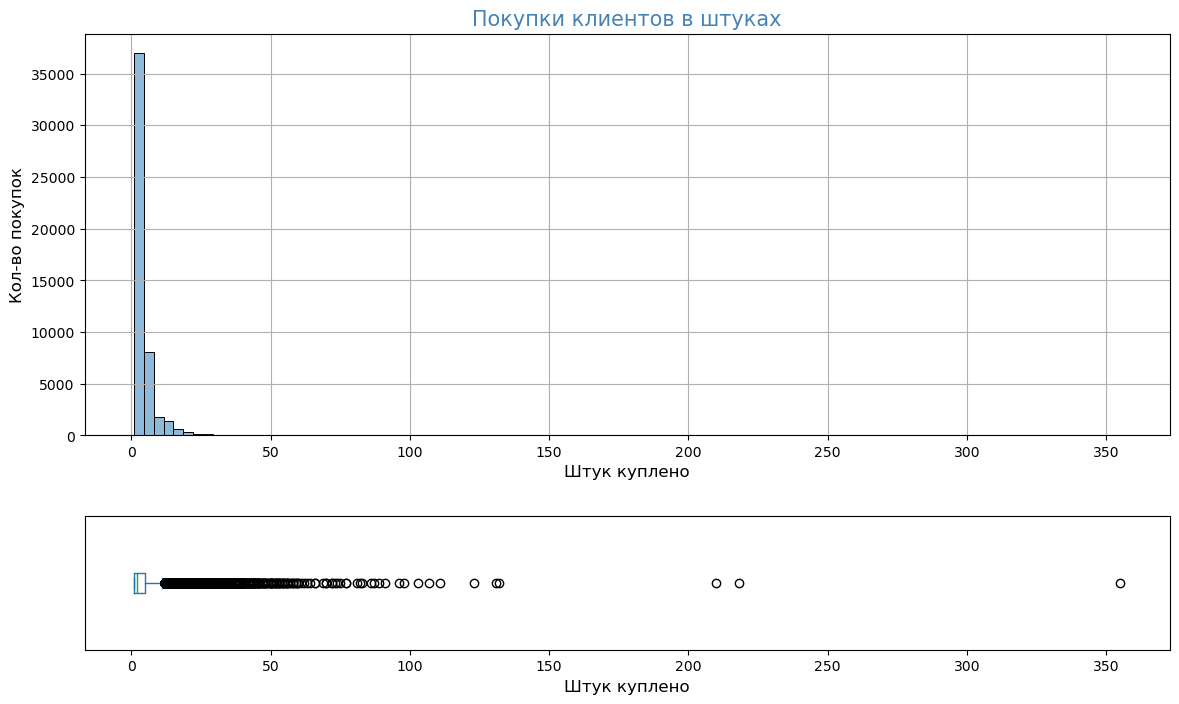

In [92]:
my_hist(grouped,
        x = 'quantity', 
        bins = 100, 
        title = 'Покупки клиентов в штуках', 
        xlabel = 'Штук куплено',
        ylabel = 'Кол-во покупок',
        xticks = np.arange(0, 400, 50),
        with_box = True)

C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


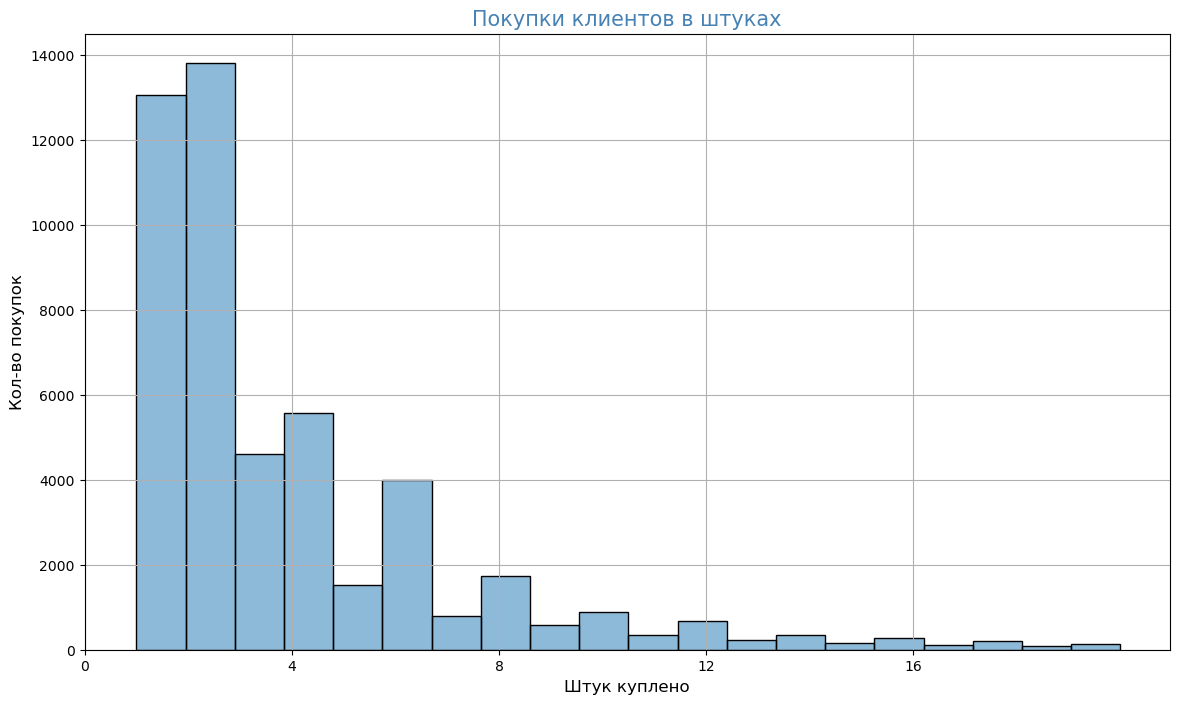

In [93]:
my_hist(grouped[grouped['quantity'] <= 20],
        x = 'quantity', 
        bins = 20, 
        title = 'Покупки клиентов в штуках', 
        xlabel = 'Штук куплено',
        ylabel = 'Кол-во покупок',
        xticks = np.arange(0, 20, 4))

Большинство клиентов покупают немного, но есть и "шопоголики", они формируют выбросы в этом показаетеле. Посмотрим в разрезе суммы.

In [94]:
my_stats(grouped['sum'])

,count,min,mean,median,max,std,0.01,0.05,0.25,0.5,0.75,0.95,0.99
total,49849.0,1.0,4865.584264,2969.0,540408.0,7351.467229,198.0,548.0,1499.0,2969.0,5698.0,14842.6,30512.16


C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


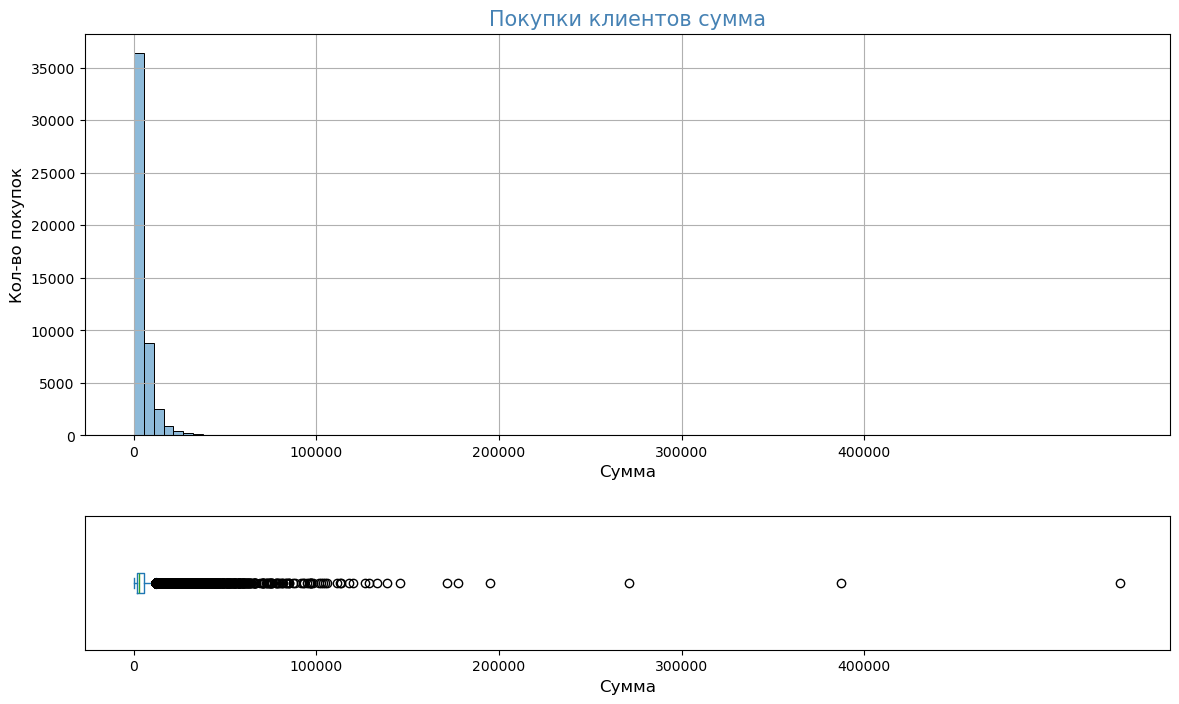

In [95]:
my_hist(grouped,
        x = 'sum', 
        bins = 100, 
        title = 'Покупки клиентов сумма', 
        xlabel = 'Сумма',
        ylabel = 'Кол-во покупок',
        xticks = np.arange(0, 500000, 100000),
        with_box = True)

C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


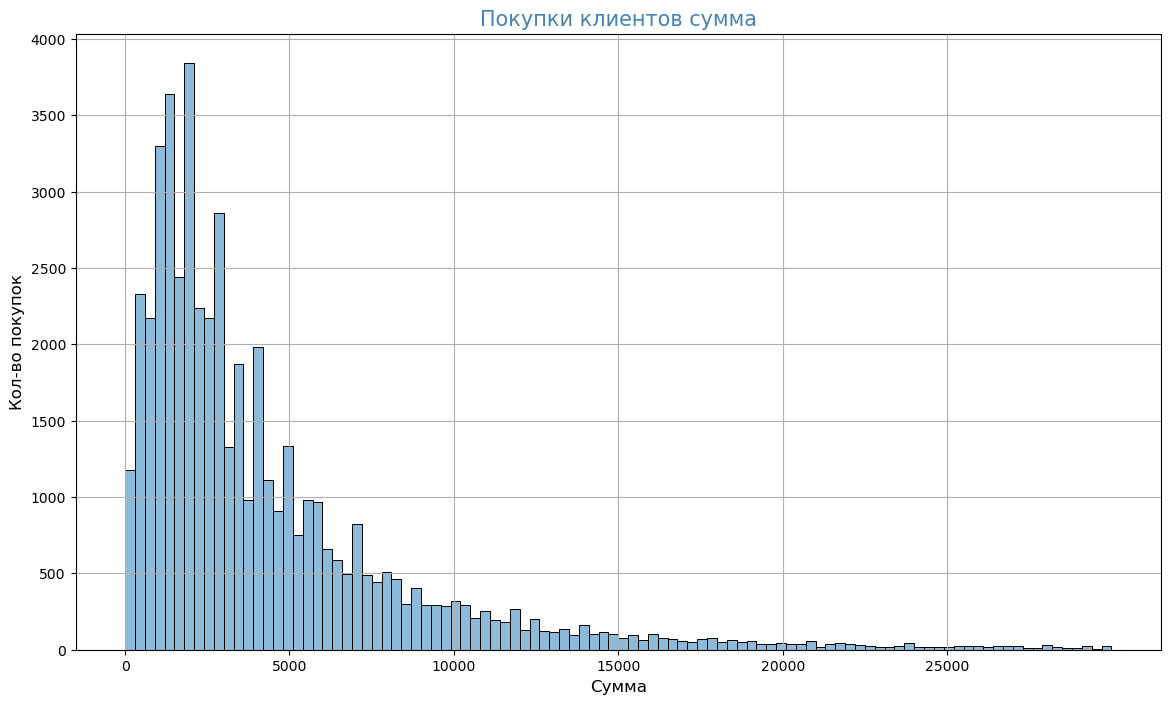

In [96]:
my_hist(grouped[grouped['sum'] <= 30000],
        x = 'sum', 
        bins = 100, 
        title = 'Покупки клиентов сумма', 
        xlabel = 'Сумма',
        ylabel = 'Кол-во покупок',
        xticks = np.arange(0, 30000, 5000))

Та же картина. Сумма имеет намного большую дисперсию, поэтому будем использовать именно ее.
Создаем консолидированный признак и сводную таблицы. 

In [97]:
apparel_purchases['final_feature'] = (apparel_purchases['category_group_id'].astype(str)
                                     .str.cat(apparel_purchases['year'].astype(str), sep='_')
                                   )

In [98]:
apparel_purchases_pivot = (apparel_purchases
                          .pivot_table(index = 'client_id',
                                       columns = 'final_feature',
                                       values = ['sum'],
                                       aggfunc = ['sum'])
                          .fillna(0)
                         ) 
apparel_purchases_pivot.columns = apparel_purchases_pivot.columns.droplevel([0, 1])
apparel_purchases_pivot.head()

final_feature,0_0_2022,0_0_2023,0_0_2024,2_17_2022,2_17_2023,2_17_2024,2_18_2022,2_18_2023,2_18_2024,4_1822_2022,...,5562_5683_2024,5963_5959_2022,5963_5959_2023,5963_5959_2024,6060_6057_2022,6060_6057_2023,6060_6057_2024,6060_6058_2022,6060_6058_2023,6060_6058_2024
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1515915625468061170,0.0,14.0,0.0,0.0,0.0,0.0,0.0,5398.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
display(f'Количество признаков: {apparel_purchases_pivot.shape[1]}')

'Количество признаков: 63'

In [100]:
apparel_purchases_pivot = optimize_memory_usage(apparel_purchases_pivot, to_int = True)

Размер использования памяти: до 24.34 Mb - после  8.94 Mb (63.3%)


In [101]:
apparel_purchases_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   0_0_2022        49849 non-null  int32
 1   0_0_2023        49849 non-null  int32
 2   0_0_2024        49849 non-null  int32
 3   2_17_2022       49849 non-null  int16
 4   2_17_2023       49849 non-null  int16
 5   2_17_2024       49849 non-null  int16
 6   2_18_2022       49849 non-null  int32
 7   2_18_2023       49849 non-null  int32
 8   2_18_2024       49849 non-null  int32
 9   4_1822_2022     49849 non-null  int16
 10  4_1822_2023     49849 non-null  int16
 11  4_1822_2024     49849 non-null  int16
 12  4_27_2022       49849 non-null  int16
 13  4_27_2023       49849 non-null  int16
 14  4_27_2024       49849 non-null  int16
 15  4_28_2022       49849 non-null  int32
 16  4_28_2023       49849 non-null  int32
 17  4_28_2024       49849 non-null  int32
 18 

In [102]:
apparel_purchases_pivot = apparel_purchases_pivot.reset_index().reset_index(drop = True)

In [103]:
apparel_purchases_pivot.head()

final_feature,client_id,0_0_2022,0_0_2023,0_0_2024,2_17_2022,2_17_2023,2_17_2024,2_18_2022,2_18_2023,2_18_2024,...,5562_5683_2024,5963_5959_2022,5963_5959_2023,5963_5959_2024,6060_6057_2022,6060_6057_2023,6060_6057_2024,6060_6058_2022,6060_6058_2023,6060_6058_2024
0,1515915625468060902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468061003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1515915625468061099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1515915625468061100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1515915625468061170,0,14,0,0,0,0,0,5398,0,...,0,0,0,0,0,0,0,0,0,0


Создаем наборы

In [104]:
features = [['category_group_id', 'year'],
            ['category_group_id'],
            ['category_group_id_light']]

In [105]:
def get_apparel_purchases_pivot(df, columns):
    cols = len(columns)
    for i, val in enumerate(columns):
        if i == 0:
            df['final_feature'] = df[val]
        else:
            df['final_feature'] = df['final_feature'].str.cat(df[val].astype(str), sep='_')    
    df_pivot = (df
                .pivot_table(index = 'client_id',
                             columns = 'final_feature',
                             values = ['sum'],
                             aggfunc = ['sum'])
                .fillna(0)
               )
    df_pivot.columns = df_pivot.columns.droplevel([0, 1])
    display(f'Количество признаков: {df_pivot.shape[1]}')
    df_pivot = optimize_memory_usage(df_pivot, to_int = True)
    df_pivot = df_pivot.reset_index().reset_index(drop = True)
    return df_pivot

In [106]:
apparel_purchases_pivot_list = []

for i in features:
    pivot = get_apparel_purchases_pivot(apparel_purchases, i)
    apparel_purchases_pivot_list.append(pivot)

'Количество признаков: 63'

Размер использования памяти: до 24.34 Mb - после  8.94 Mb (63.3%)


'Количество признаков: 21'

Размер использования памяти: до  8.37 Mb - после  3.61 Mb (56.8%)


'Количество признаков: 6'

Размер использования памяти: до  2.66 Mb - после  1.52 Mb (42.9%)


In [107]:
apparel_purchases_pivot_list[2].head()

final_feature,client_id,0,2,4,5562,5963,6060
0,1515915625468060902,0,0,6993,0,0,0
1,1515915625468061003,0,0,16235,0,0,0
2,1515915625468061099,0,0,299,0,0,0
3,1515915625468061100,0,0,2098,0,0,0
4,1515915625468061170,14,5398,28189,0,0,0


### 2.3. Дата-сет с целевым признаком apparel_target

In [108]:
apparel_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [109]:
apparel_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [110]:
apparel_target = optimize_memory_usage(apparel_target)

Размер использования памяти: до  0.76 Mb - после  0.43 Mb (43.7%)


In [111]:
apparel_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int8 
dtypes: int64(1), int8(1)
memory usage: 438.3 KB


In [112]:
my_stats(apparel_target['target'])

,count,min,mean,median,max,std,0.01,0.05,0.25,0.5,0.75,0.95,0.99
total,49849.0,0.0,0.019278,0.0,1.0,0.137503,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [113]:
apparel_target[apparel_target['client_id'].duplicated()]

,client_id,target


Все хорошо, пустот, аномалий и дубликатов нет

C:\Users\egork\AppData\Local\Temp\ipykernel_10928\4126351881.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = df.apply(lambda row: row[0] if row[2] > pie_limit else '', axis = 1)


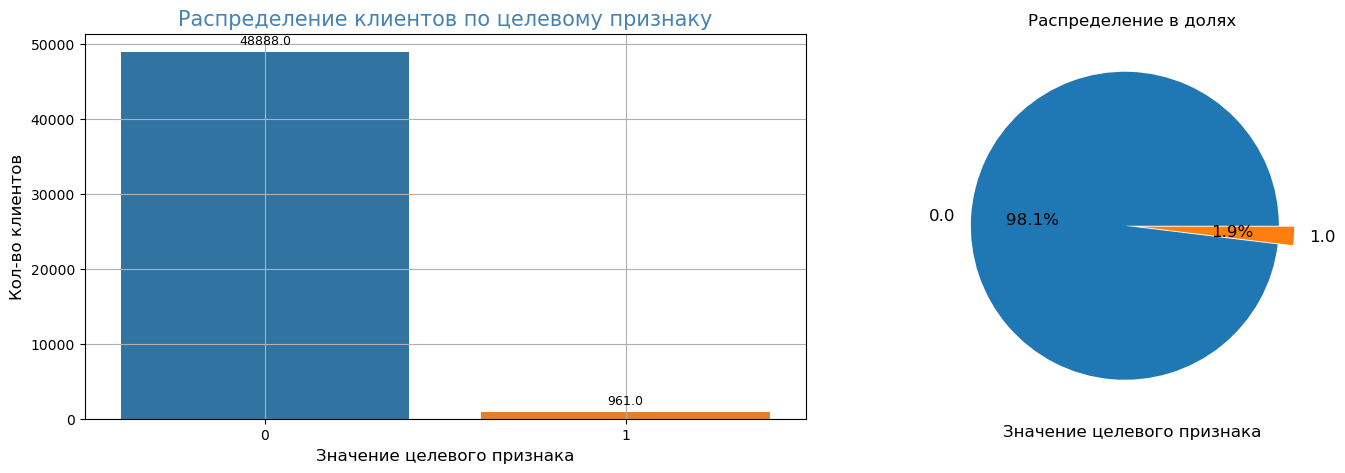

In [114]:
grouped = (get_group_set(apparel_target, 'target')
          .reset_index(drop = True)
          .sort_values(by = 'target')
          )

plot_and_pie(grouped, 
             title = 'Распределение клиентов по целевому признаку',
             xlabel = 'Значение целевого признака', 
             ylabel = 'Кол-во клиентов',
             labelrotation = 0,
             explode = [0.05] * 2 ,
             pie_limit = 1)

Целевой признак сильно несбалансирован, будем использовать стратификацию и алгоритмы, устойчивые к дисбалансу

### 2.4. Создание тренировочного и тестового дата-сетов

Объединяем дата-сеты, строки по клиентам без целевого признака нам не нужны. Также не нужны клиенты, отсутствующие в одном из дата-сетов. Будем сочетать все имеющиеся наборы дата-сетов.

In [115]:
count_rows_old_messages = apparel_messages_pivot_list[0].shape[0]
count_rows_old_purchases = apparel_purchases_pivot_list[0].shape[0]
count_rows_old_target = apparel_target.shape[0]

display(f'Клиентов с письмами до: {count_rows_old_messages}')
display(f'Клиентов с покупками до: {count_rows_old_purchases}')
display(f'Клиентов с таргетом до: {count_rows_old_target}')

final_set_list = []

for i_p in apparel_purchases_pivot_list:
    for i_m in apparel_messages_pivot_list:
        final_set = pd.merge(i_p, i_m, on = 'client_id')
        final_set = pd.merge(final_set, apparel_target, on = 'client_id')
        final_set.set_index('client_id', inplace = True)
        count_rows_new = final_set.shape[0]
        display(f'Строк в финальном сете: {count_rows_new}')
        final_set_list.append(final_set)

for i_p in apparel_purchases_pivot_list:
    final_set = pd.merge(i_p, apparel_target, on = 'client_id')
    final_set.set_index('client_id', inplace = True)
    count_rows_new = final_set.shape[0]
    display(f'Строк в финальном сете: {count_rows_new}')
    final_set_list.append(final_set)

for i_m in apparel_messages_pivot_list:
    final_set = pd.merge(i_m, apparel_target, on = 'client_id')
    final_set.set_index('client_id', inplace = True)
    count_rows_new = final_set.shape[0]
    display(f'Строк в финальном сете: {count_rows_new}')
    final_set_list.append(final_set)

'Клиентов с письмами до: 52376'

'Клиентов с покупками до: 49849'

'Клиентов с таргетом до: 49849'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 49849'

'Строк в финальном сете: 49849'

'Строк в финальном сете: 49849'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

'Строк в финальном сете: 41381'

In [116]:
final_set_list[10].head()

,0,2,4,5562,5963,6060,click_email,click_mobile_push,open_email,open_mobile_push,other,purchase_email,target
client_id,,,,,,,,,,,,,
1515915625468060902,0,0,6993,0,0,0,10,0,35,0,1,5,0
1515915625468061003,0,0,16235,0,0,0,5,0,5,0,0,1,1
1515915625468061099,0,0,299,0,0,0,8,0,17,34,2,0,0
1515915625468061100,0,0,2098,0,0,0,0,1,0,157,3,0,0
1515915625468061170,14,5398,28189,0,0,0,16,0,19,12,0,3,0


Делим сеты на тестовый и тренировочный. Сразу масштабируем данные, все признаки у нас числовые. У нас распределения имеют длинные хвосты, поэтому используем RobustScaler

In [117]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for i in final_set_list: 
    features = list(i.columns) 
    features = [x for x in features if x != 'target']
    X_train, X_test, y_train, y_test = train_test_split(i[features]
                                                        ,i['target']
                                                        ,stratify = i['target']
                                                        ,test_size = TEST_SIZE
                                                        ,random_state = RANDOM_STATE)

    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    X_train_scaled_df = optimize_memory_usage(X_train_scaled_df)
    X_test_scaled_df = optimize_memory_usage(X_test_scaled_df)

    X_train_list.append(X_train_scaled_df)
    X_test_list.append(X_test_scaled_df)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

Размер использования памяти: до 36.46 Mb - после 18.35 Mb (49.7%)
Размер использования памяти: до 12.16 Mb - после  6.12 Mb (49.7%)
Размер использования памяти: до 19.42 Mb - после  9.83 Mb (49.4%)
Размер использования памяти: до  6.47 Mb - после  3.28 Mb (49.4%)
Размер использования памяти: до 16.57 Mb - после  8.41 Mb (49.3%)
Размер использования памяти: до  5.53 Mb - после  2.80 Mb (49.3%)
Размер использования памяти: до 16.10 Mb - после  8.17 Mb (49.3%)
Размер использования памяти: до  5.37 Mb - после  2.72 Mb (49.3%)
Размер использования памяти: до 26.52 Mb - после 13.38 Mb (49.6%)
Размер использования памяти: до  8.84 Mb - после  4.46 Mb (49.6%)
Размер использования памяти: до  9.47 Mb - после  4.85 Mb (48.8%)
Размер использования памяти: до  3.16 Mb - после  1.62 Mb (48.8%)
Размер использования памяти: до  6.63 Mb - после  3.43 Mb (48.2%)
Размер использования памяти: до  2.21 Mb - после  1.14 Mb (48.2%)
Размер использования памяти: до  6.16 Mb - после  3.20 Mb (48.1%)
Размер исп

In [118]:
X_train_list[10].head()

,0,2,4,5562,5963,6060,click_email,click_mobile_push,open_email,open_mobile_push,other,purchase_email
client_id,,,,,,,,,,,,
1515915625587348973,0.0,0.0,-0.222403,0.0,0.0,0.0,0.6,0.000000,1.375000,0.000000,-1.0,0.0
1515915625502823116,14.0,0.0,0.123949,0.0,0.0,0.0,0.2,0.000000,0.333333,0.000000,-1.0,1.0
1515915625490833022,0.0,0.0,-0.026851,0.0,0.0,0.0,2.4,0.000000,3.125000,0.218750,1.0,0.0
1515915625488992627,0.0,1299.0,-0.217792,0.0,0.0,0.0,0.8,0.000000,0.291667,0.203125,-1.0,1.0
1515915625470743732,14.0,0.0,0.255764,2009.0,0.0,0.0,2.8,0.666667,1.625000,1.000000,4.0,1.0


In [119]:
X_train_list[10].shape

(31035, 12)

In [120]:
X_test_list[10].head()

,0,2,4,5562,5963,6060,click_email,click_mobile_push,open_email,open_mobile_push,other,purchase_email
client_id,,,,,,,,,,,,
1515915625589921122,0.0,0.0,-0.406564,1814.0,0.0,0.0,-0.3,4.000000,-0.333333,0.000000,2.0,-1.0
1515915625489101697,0.0,0.0,0.542175,0.0,0.0,0.0,1.0,0.333333,0.500000,1.218750,-1.0,0.0
1515915625490145073,0.0,0.0,0.894765,0.0,0.0,0.0,0.3,0.000000,0.541667,0.000000,-1.0,0.0
1515915625489686914,14.0,0.0,0.352319,0.0,0.0,0.0,1.0,0.000000,0.583333,0.000000,-1.0,0.0
1515915625589636242,0.0,0.0,0.664497,0.0,0.0,0.0,7.9,1.000000,13.375000,0.703125,0.0,1.0


In [121]:
X_test_list[10].shape

(10346, 12)

In [122]:
y_train_list[10].head()

client_id
1515915625587348973    0
1515915625502823116    0
1515915625490833022    0
1515915625488992627    0
1515915625470743732    0
Name: target, dtype: int8

In [123]:
y_train_list[10].shape

(31035,)

In [124]:
y_test_list[10].head()

client_id
1515915625589921122    0
1515915625489101697    0
1515915625490145073    0
1515915625489686914    0
1515915625589636242    0
Name: target, dtype: int8

In [125]:
y_test_list[10].shape

(10346,)

### 2.5. Корелляционный анализ

#### Проверка на мультиколлинеарность

Проверим на предмет мультиколлинеарности по Спирмену, Фик слишком медленный для такого количества столбцов. Удаляем столбцы, кореллирующие между собой.

In [126]:
corr_limit = 0.8 #отсекаем пары  такой корреляцией

for index, value in enumerate(X_train_list):
    Set_train = value.copy()
    Set_train['target'] = y_train
    Set_train_corr = Set_train.corr(method = 'spearman')
    
    #выделяем корреляцию с целевым признаком
    y_train_corr= (Set_train_corr['target']
                   .to_frame()
                   .reset_index(drop = False)\
                  )

    #матрица корреляции определяющих признаков
    Set_train_corr = (Set_train_corr
                      .drop('target', axis = 0)
                      .drop('target', axis = 1)
                     )
    #определяем пары с сильно кореллированными признаками
    X_train_corr_filtered = (Set_train_corr
                             .mask(np.eye(Set_train_corr.shape[0], dtype=bool))
                             .mask((Set_train_corr < corr_limit) & (Set_train_corr > -corr_limit))
                             .stack()
                            )
    X_train_corr_filtered = (X_train_corr_filtered
                             .to_frame()
                             .reset_index(drop = False)
                            )
    #считаем для каждой такой пары корелляцию с таргетом
    Set_train_corr_filtered = (X_train_corr_filtered
                               .merge(y_train_corr,
                                      left_on = 'level_0',
                                      right_on = 'index',
                                      how = 'left')
                               .drop('index', axis = 1)
                               .rename(columns = {'target':'coeff_0'})
                               .merge(y_train_corr,
                                      left_on = 'level_1',
                                      right_on = 'index',
                                      how = 'left')
                               .drop('index', axis = 1)
                               .rename(columns = {'target':'coeff_1'})
                              )
    #столбцы с меньшей связью с таргетом для удаления
    looser_columns = (Set_train_corr_filtered
                      .apply(lambda row: row['level_0'] if row['coeff_0'] < row['coeff_1'] else row['level_1'], axis = 1)
                      .drop_duplicates()
                     )
    looser_columns_list = list(looser_columns)
    #удаляем такие столбцы
    display(f'Номер выборки: {index}')
    count_cols_old = value.shape[1]
    display(f'Столбцов в обучающей выборке до удаления лузеров: {count_cols_old}')
    
    X_train_list[index].drop(looser_columns_list, axis = 1, inplace = True)
    X_test_list[index].drop(looser_columns_list, axis = 1, inplace = True)
    
    count_cols_new = X_train_list[index].shape[1]
    display(f'Строк в обучающей выборке после удаления лузеров: {count_cols_new}')
    display(f'Удалено {((count_cols_old - count_cols_new) / count_cols_old):.3%}')
    display('')

'Номер выборки: 0'

'Столбцов в обучающей выборке до удаления лузеров: 153'

'Строк в обучающей выборке после удаления лузеров: 146'

'Удалено 4.575%'

''

'Номер выборки: 1'

'Столбцов в обучающей выборке до удаления лузеров: 81'

'Строк в обучающей выборке после удаления лузеров: 78'

'Удалено 3.704%'

''

'Номер выборки: 2'

'Столбцов в обучающей выборке до удаления лузеров: 69'

'Строк в обучающей выборке после удаления лузеров: 68'

'Удалено 1.449%'

''

'Номер выборки: 3'

'Столбцов в обучающей выборке до удаления лузеров: 67'

'Строк в обучающей выборке после удаления лузеров: 67'

'Удалено 0.000%'

''

'Номер выборки: 4'

'Столбцов в обучающей выборке до удаления лузеров: 111'

'Строк в обучающей выборке после удаления лузеров: 104'

'Удалено 6.306%'

''

'Номер выборки: 5'

'Столбцов в обучающей выборке до удаления лузеров: 39'

'Строк в обучающей выборке после удаления лузеров: 36'

'Удалено 7.692%'

''

'Номер выборки: 6'

'Столбцов в обучающей выборке до удаления лузеров: 27'

'Строк в обучающей выборке после удаления лузеров: 26'

'Удалено 3.704%'

''

'Номер выборки: 7'

'Столбцов в обучающей выборке до удаления лузеров: 25'

'Строк в обучающей выборке после удаления лузеров: 25'

'Удалено 0.000%'

''

'Номер выборки: 8'

'Столбцов в обучающей выборке до удаления лузеров: 96'

'Строк в обучающей выборке после удаления лузеров: 89'

'Удалено 7.292%'

''

'Номер выборки: 9'

'Столбцов в обучающей выборке до удаления лузеров: 24'

'Строк в обучающей выборке после удаления лузеров: 21'

'Удалено 12.500%'

''

'Номер выборки: 10'

'Столбцов в обучающей выборке до удаления лузеров: 12'

'Строк в обучающей выборке после удаления лузеров: 11'

'Удалено 8.333%'

''

'Номер выборки: 11'

'Столбцов в обучающей выборке до удаления лузеров: 10'

'Строк в обучающей выборке после удаления лузеров: 10'

'Удалено 0.000%'

''

'Номер выборки: 12'

'Столбцов в обучающей выборке до удаления лузеров: 63'

'Строк в обучающей выборке после удаления лузеров: 63'

'Удалено 0.000%'

''

'Номер выборки: 13'

'Столбцов в обучающей выборке до удаления лузеров: 21'

'Строк в обучающей выборке после удаления лузеров: 21'

'Удалено 0.000%'

''

'Номер выборки: 14'

'Столбцов в обучающей выборке до удаления лузеров: 6'

'Строк в обучающей выборке после удаления лузеров: 6'

'Удалено 0.000%'

''

'Номер выборки: 15'

'Столбцов в обучающей выборке до удаления лузеров: 90'

'Строк в обучающей выборке после удаления лузеров: 83'

'Удалено 7.778%'

''

'Номер выборки: 16'

'Столбцов в обучающей выборке до удаления лузеров: 18'

'Строк в обучающей выборке после удаления лузеров: 15'

'Удалено 16.667%'

''

'Номер выборки: 17'

'Столбцов в обучающей выборке до удаления лузеров: 6'

'Строк в обучающей выборке после удаления лузеров: 5'

'Удалено 16.667%'

''

'Номер выборки: 18'

'Столбцов в обучающей выборке до удаления лузеров: 4'

'Строк в обучающей выборке после удаления лузеров: 4'

'Удалено 0.000%'

''

In [127]:
X_train_list[10].head()

,0,2,4,5562,5963,6060,click_mobile_push,open_email,open_mobile_push,other,purchase_email
client_id,,,,,,,,,,,
1515915625587348973,0.0,0.0,-0.222403,0.0,0.0,0.0,0.000000,1.375000,0.000000,-1.0,0.0
1515915625502823116,14.0,0.0,0.123949,0.0,0.0,0.0,0.000000,0.333333,0.000000,-1.0,1.0
1515915625490833022,0.0,0.0,-0.026851,0.0,0.0,0.0,0.000000,3.125000,0.218750,1.0,0.0
1515915625488992627,0.0,1299.0,-0.217792,0.0,0.0,0.0,0.000000,0.291667,0.203125,-1.0,1.0
1515915625470743732,14.0,0.0,0.255764,2009.0,0.0,0.0,0.666667,1.625000,1.000000,4.0,1.0


#### Отбор признаков методом фильтрации

Посмотрим на взаимную информацию между признаками и таргетом

In [128]:
mutual_info_list = []

for i in range(len(X_train_list)):
    mutual_limit = 0 #столбцы с такой мерой информации будем удалять 
    feature_names = X_train_list[i].columns
    
    mutual_info = mutual_info_classif(X_train_list[i], y_train_list[i], random_state = RANDOM_STATE)
    mutual_info_df = pd.DataFrame(mutual_info, index=feature_names, columns=["mutual_information"])
    mutual_info_list.append(mutual_info_df)
    #удаляем стобцы без взаимной информации с таргетом
    mutual_info_df = mutual_info_df.reset_index(drop = False)
    looser_columns = mutual_info_df.loc[mutual_info_df['mutual_information'] <= mutual_limit, 'index']
    looser_columns_list = list(looser_columns)
    
    display(f'Номер выборки: {i}')
    count_cols_old = X_train_list[i].shape[1]
    display(f'Столбцов в обучающей выборке до удаления лузеров: {count_cols_old}')
    
    X_train_list[i].drop(looser_columns_list, axis = 1, inplace = True)
    X_test_list[i].drop(looser_columns_list, axis = 1, inplace = True)

    count_cols_new = X_train_list[i].shape[1]
    display(f'Строк в обучающей выборке после удаления лузеров: {count_cols_new}')
    display(f'Удалено {((count_cols_old - count_cols_new) / count_cols_old):.3%}')
    display('')

'Номер выборки: 0'

'Столбцов в обучающей выборке до удаления лузеров: 146'

'Строк в обучающей выборке после удаления лузеров: 97'

'Удалено 33.562%'

''

'Номер выборки: 1'

'Столбцов в обучающей выборке до удаления лузеров: 78'

'Строк в обучающей выборке после удаления лузеров: 49'

'Удалено 37.179%'

''

'Номер выборки: 2'

'Столбцов в обучающей выборке до удаления лузеров: 68'

'Строк в обучающей выборке после удаления лузеров: 37'

'Удалено 45.588%'

''

'Номер выборки: 3'

'Столбцов в обучающей выборке до удаления лузеров: 67'

'Строк в обучающей выборке после удаления лузеров: 30'

'Удалено 55.224%'

''

'Номер выборки: 4'

'Столбцов в обучающей выборке до удаления лузеров: 104'

'Строк в обучающей выборке после удаления лузеров: 64'

'Удалено 38.462%'

''

'Номер выборки: 5'

'Столбцов в обучающей выборке до удаления лузеров: 36'

'Строк в обучающей выборке после удаления лузеров: 33'

'Удалено 8.333%'

''

'Номер выборки: 6'

'Столбцов в обучающей выборке до удаления лузеров: 26'

'Строк в обучающей выборке после удаления лузеров: 16'

'Удалено 38.462%'

''

'Номер выборки: 7'

'Столбцов в обучающей выборке до удаления лузеров: 25'

'Строк в обучающей выборке после удаления лузеров: 18'

'Удалено 28.000%'

''

'Номер выборки: 8'

'Столбцов в обучающей выборке до удаления лузеров: 89'

'Строк в обучающей выборке после удаления лузеров: 61'

'Удалено 31.461%'

''

'Номер выборки: 9'

'Столбцов в обучающей выборке до удаления лузеров: 21'

'Строк в обучающей выборке после удаления лузеров: 19'

'Удалено 9.524%'

''

'Номер выборки: 10'

'Столбцов в обучающей выборке до удаления лузеров: 11'

'Строк в обучающей выборке после удаления лузеров: 6'

'Удалено 45.455%'

''

'Номер выборки: 11'

'Столбцов в обучающей выборке до удаления лузеров: 10'

'Строк в обучающей выборке после удаления лузеров: 7'

'Удалено 30.000%'

''

'Номер выборки: 12'

'Столбцов в обучающей выборке до удаления лузеров: 63'

'Строк в обучающей выборке после удаления лузеров: 36'

'Удалено 42.857%'

''

'Номер выборки: 13'

'Столбцов в обучающей выборке до удаления лузеров: 21'

'Строк в обучающей выборке после удаления лузеров: 12'

'Удалено 42.857%'

''

'Номер выборки: 14'

'Столбцов в обучающей выборке до удаления лузеров: 6'

'Строк в обучающей выборке после удаления лузеров: 5'

'Удалено 16.667%'

''

'Номер выборки: 15'

'Столбцов в обучающей выборке до удаления лузеров: 83'

'Строк в обучающей выборке после удаления лузеров: 55'

'Удалено 33.735%'

''

'Номер выборки: 16'

'Столбцов в обучающей выборке до удаления лузеров: 15'

'Строк в обучающей выборке после удаления лузеров: 12'

'Удалено 20.000%'

''

'Номер выборки: 17'

'Столбцов в обучающей выборке до удаления лузеров: 5'

'Строк в обучающей выборке после удаления лузеров: 5'

'Удалено 0.000%'

''

'Номер выборки: 18'

'Столбцов в обучающей выборке до удаления лузеров: 4'

'Строк в обучающей выборке после удаления лузеров: 3'

'Удалено 25.000%'

''

Вот такая каритина была 

In [129]:
mutual_info_list[10].head()

,mutual_information
0,0.000000
2,0.000000
4,0.001819
5562,0.000471
5963,0.000034


C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


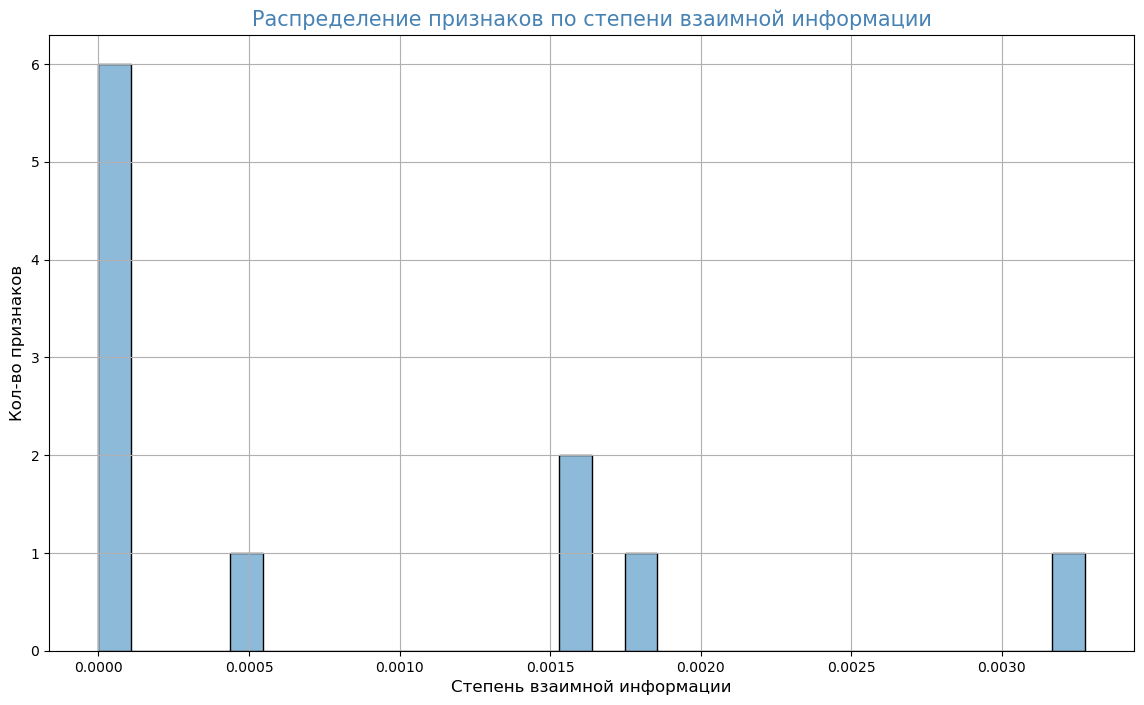

In [130]:
my_hist(mutual_info_list[10],
        x = 'mutual_information', 
        bins = 30, 
        title = 'Распределение признаков по степени взаимной информации', 
        xlabel = 'Степень взаимной информации',
        ylabel = 'Кол-во признаков')

В итоге у нас осталась только часть признаков, в дальнейшем будем также использовать в моделях такие встроенные методы как Lasso и ElasticNet

Удаляем дубли в тренировочной выборке

In [131]:
for i in range(len(X_train_list)):
    X_train_list[i]['target'] = y_train_list[i]

    #заодно делаем таким образом неявный OverSampling минорного признака
    mask_0 = X_train_list[i]['target'] == 0
    mask_1 = X_train_list[i]['target'] == 1
 
    count_rows_old = X_train_list[i].shape[0]
    count_rows_old_0 = X_train_list[i][mask_0].shape[0]
    count_rows_old_1 = X_train_list[i][mask_1].shape[0]
    
    #display(f'Строк с таргетом 0 до удаления дублей: {count_rows_old_0}')
    #display(f'Строк с таргетом 1 до удаления дублей: {count_rows_old_1}')
    
    df_target_0 = X_train_list[i][mask_0].drop_duplicates() 
    df_target_1 = X_train_list[i][mask_1]
    X_train_list[i] = pd.concat([df_target_0, df_target_1], axis = 0)

    # Пересоздаём маски после изменения DataFrame
    mask_0 = X_train_list[i]['target'] == 0
    mask_1 = X_train_list[i]['target'] == 1
    
    count_rows_new = X_train_list[i].shape[0]
    count_rows_new_0 = X_train_list[i][mask_0].shape[0]
    count_rows_new_1 = X_train_list[i][mask_1].shape[0]
    display(f'Номер выборки: {i}')
    display(f'Строк в тренировочной выборке до удаления дублей: {count_rows_old}')
    display(f'Строк в тренировочной выборке после удаления дублей: {count_rows_new}')
    display(f'Удалено строк всего: {((count_rows_old - count_rows_new) / count_rows_old):.3%}')
    #display(f'Строк с таргетом 0 после удаления дублей: {count_rows_new_0}')
    #display(f'Удалено строк с таргетом 0: {((count_rows_old_0 - count_rows_new_0) / count_rows_old_0):.3%}')
    #display(f'Строк с таргетом 1 после удаления дублей: {count_rows_new_1}')
    #display(f'Удалено строк с таргетом 1: {((count_rows_old_1 - count_rows_new_1) / count_rows_old_1):.3%}')
    display(f'Дисбаланс таргета до удаления дублей: {(count_rows_old_1 / count_rows_old_0):.3%}')
    display(f'Дисбаланс таргета после удаления дублей: {(count_rows_new_1 / count_rows_new_0):.3%}')
    display('')

    y_train_list[i] = X_train_list[i]['target']
    X_train_list[i].drop(['target'], axis = 1, inplace = True) 

'Номер выборки: 0'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 30525'

'Удалено строк всего: 1.643%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.111%'

''

'Номер выборки: 1'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 26788'

'Удалено строк всего: 13.685%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.412%'

''

'Номер выборки: 2'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 19745'

'Удалено строк всего: 36.378%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 3.301%'

''

'Номер выборки: 3'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 25089'

'Удалено строк всего: 19.159%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.580%'

''

'Номер выборки: 4'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 30402'

'Удалено строк всего: 2.040%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.120%'

''

'Номер выборки: 5'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 30391'

'Удалено строк всего: 2.075%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.120%'

''

'Номер выборки: 6'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 27769'

'Удалено строк всего: 10.524%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.325%'

''

'Номер выборки: 7'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 28516'

'Удалено строк всего: 8.117%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.263%'

''

'Номер выборки: 8'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 30754'

'Удалено строк всего: 0.905%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.095%'

''

'Номер выборки: 9'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 30281'

'Удалено строк всего: 2.430%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.128%'

''

'Номер выборки: 10'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 21451'

'Удалено строк всего: 30.881%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 3.031%'

''

'Номер выборки: 11'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 29094'

'Удалено строк всего: 6.254%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.217%'

''

'Номер выборки: 12'

'Строк в тренировочной выборке до удаления дублей: 37386'

'Строк в тренировочной выборке после удаления дублей: 13165'

'Удалено строк всего: 64.786%'

'Дисбаланс таргета до удаления дублей: 1.966%'

'Дисбаланс таргета после удаления дублей: 5.794%'

''

'Номер выборки: 13'

'Строк в тренировочной выборке до удаления дублей: 37386'

'Строк в тренировочной выборке после удаления дублей: 13555'

'Удалено строк всего: 63.743%'

'Дисбаланс таргета до удаления дублей: 1.966%'

'Дисбаланс таргета после удаления дублей: 5.618%'

''

'Номер выборки: 14'

'Строк в тренировочной выборке до удаления дублей: 37386'

'Строк в тренировочной выборке после удаления дублей: 14553'

'Удалено строк всего: 61.074%'

'Дисбаланс таргета до удаления дублей: 1.966%'

'Дисбаланс таргета после удаления дублей: 5.213%'

''

'Номер выборки: 15'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 28119'

'Удалено строк всего: 9.396%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 2.296%'

''

'Номер выборки: 16'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 18502'

'Удалено строк всего: 40.383%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 3.531%'

''

'Номер выборки: 17'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 15886'

'Удалено строк всего: 48.813%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 4.136%'

''

'Номер выборки: 18'

'Строк в тренировочной выборке до удаления дублей: 31035'

'Строк в тренировочной выборке после удаления дублей: 12214'

'Удалено строк всего: 60.644%'

'Дисбаланс таргета до удаления дублей: 2.075%'

'Дисбаланс таргета после удаления дублей: 5.448%'

''

## 3. Обучение моделей

Так как у наборы данных широкие, могут содержать до 100 признаков, и целевой признак крайне не сбалансирован, целесообразно применить древесные алгоритмы, а также градиентный бустинг.

In [132]:
#контейнер для моделей
models_dict = {
        'Тип модели' : [],
        'Номер выборки' : [],
        'Модель' : [],
        'Параметры модели' : [],
        'ROC_AUC' : (-1) * [],
        'Время оптимизации, сек' : [],
        'Время обучения, сек' : [],
        'Время предсказания, сек' : []
    }

### 3.1. Ансамбль случайных деревьев

In [133]:
#чтобы тетрадь долго у тебя не висела, после отработки GridSearch
#я выставил диапазоны параметров на найденный оптимум 

for i in [0, 5, 8, 9, 17]:     
    n_estimators = [1500]
    max_features = [5]
    max_depth = [4]

    param_grid_list = [
        {'models': [RandomForestClassifier(random_state = RANDOM_STATE,
                                           n_jobs = -1,
                                           class_weight='balanced'
                                          )],
         'models__n_estimators' : n_estimators,
         'models__max_features' : max_features,
         'models__max_depth' : max_depth
        }]

    models_dict_row  = get_best_model(X_train_list[i],
                                      y_train_list[i],
                                      i,
                                      RandomForestClassifier(),
                                      'Ансамбль случайных деревьев',
                                      param_grid_list)
    models_dict = {key: models_dict[key] + models_dict_row[key] for key in models_dict}

Номер выборки: 0
Время оптимизации: 51.81 сек
Время обучения: 34.98 сек
Время предсказания: 1.82 сек
Лучшие параметры: {'models': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=124), 'models__max_depth': 4, 'models__max_features': 5, 'models__n_estimators': 1500}
Лучшая метрика: 0.736

Номер выборки: 5
Время оптимизации: 66.21 сек
Время обучения: 43.42 сек
Время предсказания: 2.52 сек
Лучшие параметры: {'models': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=124), 'models__max_depth': 4, 'models__max_features': 5, 'models__n_estimators': 1500}
Лучшая метрика: 0.736

Номер выборки: 8
Время оптимизации: 62.80 сек
Время обучения: 40.60 сек
Время предсказания: 2.40 сек
Лучшие параметры: {'models': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=124), 'models__max_depth': 4, 'models__max_features': 5, 'models__n_estimators': 1500}
Лучшая метрика: 0.736

Номер выборки: 9
Время оптимизации: 75.24 сек
Время обучения: 38

### 3.2. Градиентный бустинг LGBM

In [134]:
#чтобы тетрадь долго у тебя не висела, эту вообще отключил, показывает метрики заведомо ниже других
"""
for i in range(len(X_train_list)):
    max_depth = [5]
    reg_alpha = [0.1, 0.3, 0.5, 0.7]
    reg_lambda = [0.1, 0.3, 0.5, 0.7]


    param_grid_list = [
        {'models': [LGBMClassifier(random_state = RANDOM_STATE,
                                   n_jobs = -1,
                                   class_weight='balanced',
                                   verbose = -1
                                  )],
         'models__max_depth' : max_depth,
         'models__reg_alpha' : reg_alpha,
         'models__reg_lambda' : reg_lambda
        }]


    models_dict_row  = get_best_model(X_train_list[i],
                                      y_train_list[i],
                                      i,
                                      LGBMClassifier(),
                                      'Градиентный бустинг LGBM',
                                      param_grid_list)
    models_dict = {key: models_dict[key] + models_dict_row[key] for key in models_dict}"""


"\nfor i in range(len(X_train_list)):\n    max_depth = [5]\n    reg_alpha = [0.1, 0.3, 0.5, 0.7]\n    reg_lambda = [0.1, 0.3, 0.5, 0.7]\n\n\n    param_grid_list = [\n        {'models': [LGBMClassifier(random_state = RANDOM_STATE,\n                                   n_jobs = -1,\n                                   class_weight='balanced',\n                                   verbose = -1\n                                  )],\n         'models__max_depth' : max_depth,\n         'models__reg_alpha' : reg_alpha,\n         'models__reg_lambda' : reg_lambda\n        }]\n\n\n    models_dict_row  = get_best_model(X_train_list[i],\n                                      y_train_list[i],\n                                      i,\n                                      LGBMClassifier(),\n                                      'Градиентный бустинг LGBM',\n                                      param_grid_list)\n    models_dict = {key: models_dict[key] + models_dict_row[key] for key in models_dict}"

### 3.3. Градиентный бустинг CatBoost

In [135]:
#чтобы тетрадь долго у тебя не висела, после отработки GridSearch
#я выставил диапазоны параметров на найденный оптимум 

for i in [0, 5, 8, 9, 17]:
    iterations = [100]
    learning_rate = [0.03]
    depth = [8]
    l2_leaf_reg = [5]


    param_grid_list = [
        {'models': [CatBoostClassifier(auto_class_weights='Balanced',        
                                       random_state = RANDOM_STATE,
                                       verbose = 0,
                                       eval_metric='AUC'
                                      )],
         'models__iterations' : iterations,
         'models__learning_rate' : learning_rate,
         'models__depth' : depth,
         'models__l2_leaf_reg' : l2_leaf_reg
        }]


    models_dict_row  = get_best_model(X_train_list[i],
                                      y_train_list[i],
                                      i,
                                      CatBoostClassifier(),
                                      'Градиентный бустинг CatBoost',
                                      param_grid_list)
    models_dict = {key: models_dict[key] + models_dict_row[key] for key in models_dict}

Номер выборки: 0
Время оптимизации: 40.03 сек
Время обучения: 28.69 сек
Время предсказания: 0.07 сек
Лучшие параметры: {'models': <catboost.core.CatBoostClassifier object at 0x0000021E8E777C50>, 'models__depth': 8, 'models__iterations': 100, 'models__l2_leaf_reg': 5, 'models__learning_rate': 0.03}
Лучшая метрика: 0.730

Номер выборки: 5
Время оптимизации: 32.23 сек
Время обучения: 22.91 сек
Время предсказания: 0.04 сек
Лучшие параметры: {'models': <catboost.core.CatBoostClassifier object at 0x0000021EE3873090>, 'models__depth': 8, 'models__iterations': 100, 'models__l2_leaf_reg': 5, 'models__learning_rate': 0.03}
Лучшая метрика: 0.728

Номер выборки: 8
Время оптимизации: 24.75 сек
Время обучения: 16.22 сек
Время предсказания: 0.05 сек
Лучшие параметры: {'models': <catboost.core.CatBoostClassifier object at 0x0000021EE3882E90>, 'models__depth': 8, 'models__iterations': 100, 'models__l2_leaf_reg': 5, 'models__learning_rate': 0.03}
Лучшая метрика: 0.724

Номер выборки: 9
Время оптимизации

## 4. Выбор и анализ модели

### 4.1. Выбор лучшей модели

Посмотрим результаты. 

In [136]:
models_frame = pd.DataFrame(models_dict)

In [137]:
keys_for_print = ['Тип модели',
                  'Номер выборки',
                  'ROC_AUC',
                  'Время оптимизации, сек',
                  'Время обучения, сек',
                  'Время предсказания, сек' 
                 ]
models_dict_for_print = {key: models_dict[key] for key in keys_for_print if key in models_dict}
models_frame_for_print = pd.DataFrame(models_dict_for_print) #.sort_values(by = 'ROC_AUC', ascending = False)
models_frame_for_print

,Тип модели,Номер выборки,ROC_AUC,"Время оптимизации, сек","Время обучения, сек","Время предсказания, сек"
0,Ансамбль случайных деревьев,0,0.736,51.81,34.98,1.82
1,Ансамбль случайных деревьев,5,0.736,66.21,43.42,2.52
2,Ансамбль случайных деревьев,8,0.736,62.80,40.60,2.40
3,Ансамбль случайных деревьев,9,0.736,75.24,38.02,1.83
4,Ансамбль случайных деревьев,17,0.749,54.07,40.38,1.67
5,Градиентный бустинг CatBoost,0,0.730,40.03,28.69,0.07
6,Градиентный бустинг CatBoost,5,0.728,32.23,22.91,0.04
7,Градиентный бустинг CatBoost,8,0.724,24.75,16.22,0.05
8,Градиентный бустинг CatBoost,9,0.734,12.75,6.56,0.03
9,Градиентный бустинг CatBoost,17,0.744,5.68,3.89,0.02


Самой лучшей оказалась модель случайных деревьев, обученная на наборе признаков 17, с метрикой Roc_Auc на уровне 0.749.  Гиперпараметры итоговой модели:

In [138]:
best_model_index = 4 # индекс выбранной модели в итоговой таблице
best_set_number = models_dict.get('Номер выборки')[best_model_index] #номер лучшей выборки

In [139]:
X_train_list[best_set_number].columns

Index(['click_mobile_push', 'open_email', 'open_mobile_push', 'other',
       'purchase_email'],
      dtype='object')

In [140]:
models_dict.get('Параметры модели')[best_model_index]

{'models': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=124),
 'models__max_depth': 4,
 'models__max_features': 5,
 'models__n_estimators': 1500}

### 4.2. Проверка метрик на тестовой выборке

In [141]:
model = models_dict.get('Модель')[best_model_index] 
y_predict_proba = list(model.predict_proba(X_test_list[best_set_number])[:,1])

In [142]:
y_true = list(y_test_list[best_set_number])
roc_auc = roc_auc_score(y_true, y_predict_proba)
display(f'Метрика ROC_AUC лучшей модели на валидационных выборках: {models_dict.get("ROC_AUC")[best_model_index]}')
display(f'Метрика ROC_AUC лучшей модели на тестовых данных: {roc_auc:.3f}')

'Метрика ROC_AUC лучшей модели на валидационных выборках: 0.749'

'Метрика ROC_AUC лучшей модели на тестовых данных: 0.483'

Видимо, что модель сильно переобучена, она сумела хорошо подстроиться к такому ограниченному набору признаков за 1500 итераций. Посмотрим что с переобучением моделей, обученных на более сложных выборках и моделей CatBoost. Придется выбирать другую модель и, возможно, перенастраивать гиперпараметры.

In [143]:
roc_auc_test = []

for i in range(len(models_dict.get('Модель'))):
    model = models_dict.get('Модель')[i]
    set_number = models_dict.get('Номер выборки')[i]
    y_predict_proba = list(model.predict_proba(X_test_list[set_number])[:,1])
    y_true = list(y_test_list[set_number])
    roc_auc = round(roc_auc_score(y_true, y_predict_proba),3)
    roc_auc_test.append(roc_auc)

models_dict['ROC_AUC_test'] = roc_auc_test
models_frame = pd.DataFrame(models_dict)

In [144]:
keys_for_print = ['Тип модели',
                  'Номер выборки',
                  'Время оптимизации, сек',
                  'Время обучения, сек',
                  'Время предсказания, сек',
                  'ROC_AUC',
                  'ROC_AUC_test',
                 ]
models_dict_for_print = {key: models_dict[key] for key in keys_for_print if key in models_dict}
models_frame_for_print = pd.DataFrame(models_dict_for_print) #.sort_values(by = 'ROC_AUC', ascending = False)
models_frame_for_print

,Тип модели,Номер выборки,"Время оптимизации, сек","Время обучения, сек","Время предсказания, сек",ROC_AUC,ROC_AUC_test
0,Ансамбль случайных деревьев,0,51.81,34.98,1.82,0.736,0.726
1,Ансамбль случайных деревьев,5,66.21,43.42,2.52,0.736,0.737
2,Ансамбль случайных деревьев,8,62.80,40.60,2.40,0.736,0.724
3,Ансамбль случайных деревьев,9,75.24,38.02,1.83,0.736,0.740
4,Ансамбль случайных деревьев,17,54.07,40.38,1.67,0.749,0.483
5,Градиентный бустинг CatBoost,0,40.03,28.69,0.07,0.730,0.727
6,Градиентный бустинг CatBoost,5,32.23,22.91,0.04,0.728,0.714
7,Градиентный бустинг CatBoost,8,24.75,16.22,0.05,0.724,0.715
8,Градиентный бустинг CatBoost,9,12.75,6.56,0.03,0.734,0.738
9,Градиентный бустинг CatBoost,17,5.68,3.89,0.02,0.744,0.505


Да, так и есть, выборка 17 оказалась слишком простой, в ней нет сложных реальных взаимозависимостей, за которые можно зацепиться и модель просто под нее подстроилась, причем подстроилась хорошо. Придется выбрать модель с чуть меньшей метрикой. И это будет тот же случайный лес. Все оставшиеся модели хорошо обучены, попробуем выбрать модель с наиболее простым набором признаков.

In [145]:
for i in [1, 2, 3]:
    set_number = models_dict.get('Номер выборки')[i]
    display(f'Номер модели : {i}')
    display(f'Номер выборки: {set_number}')
    display(X_train_list[i].columns)

'Номер модели : 1'

'Номер выборки: 5'

Index(['0_0_2022', '0_0_2023', '2_17_2022', '2_17_2024', '2_18_2023',
       '2_18_2024', '4_1822_2022', '4_1822_2024', '4_27_2022', '4_27_2023',
       '4_28_2023', '4_28_2024', '4_29_2024', '4_31_2022', '4_31_2023',
       '4_44_2022', '4_44_2023', '4_44_2024', '5562_5536_2022',
       '5562_5536_2024', '5562_5589_2022', '5562_5597_2022', '5562_5630_2022',
       '5562_5630_2024', '5562_5631_2022', '5562_5631_2024', '5562_5632_2022',
       '5562_5632_2023', '5562_5633_2022', '5562_5633_2023', '5562_5634_2023',
       '5562_5683_2022', '6060_6057_2022', '6060_6057_2023', '6060_6058_2022',
       '6060_6058_2024', 'click_email_2023', 'click_email_2024',
       'click_mobile_push_2023', 'click_mobile_push_2024', 'open_email_2022',
       'open_mobile_push_2022', 'open_mobile_push_2024', 'other_2022',
       'other_2023', 'other_2024', 'purchase_email_2022',
       'purchase_email_2023', 'purchase_email_2024'],
      dtype='object')

'Номер модели : 2'

'Номер выборки: 8'

Index(['0_0_2022', '2_17_2022', '2_17_2023', '2_18_2022', '4_1822_2022',
       '4_1822_2024', '4_27_2023', '4_27_2024', '4_28_2023', '4_28_2024',
       '4_29_2022', '4_29_2024', '4_31_2023', '4_31_2024', '4_44_2023',
       '5562_5536_2022', '5562_5536_2024', '5562_5589_2022', '5562_5589_2024',
       '5562_5597_2023', '5562_5630_2023', '5562_5631_2022', '5562_5631_2024',
       '5562_5632_2022', '5562_5632_2024', '5562_5633_2022', '5562_5633_2024',
       '5562_5683_2024', '5963_5959_2022', '5963_5959_2023', '6060_6057_2022',
       '6060_6057_2023', '6060_6058_2024', 'click_mobile_push',
       'open_mobile_push', 'other', 'purchase_email'],
      dtype='object')

'Номер модели : 3'

'Номер выборки: 9'

Index(['0_0_2023', '2_17_2022', '2_17_2024', '2_18_2022', '4_1822_2023',
       '4_1822_2024', '4_27_2022', '4_27_2023', '4_27_2024', '4_28_2023',
       '4_28_2024', '4_29_2024', '4_31_2022', '4_31_2024', '4_44_2024',
       '5562_5536_2023', '5562_5536_2024', '5562_5589_2024', '5562_5597_2022',
       '5562_5630_2023', '5562_5631_2022', '5562_5632_2023', '5562_5634_2023',
       '5562_5683_2024', '5963_5959_2022', '6060_6058_2023', 'click', 'open',
       'other', 'purchase'],
      dtype='object')

In [146]:
best_model_index = 3 # индекс выбранной модели в итоговой таблице
best_set_number = models_dict.get('Номер выборки')[best_model_index] #номер лучшей выборки

In [147]:
models_dict.get('Параметры модели')[best_model_index]

{'models': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=124),
 'models__max_depth': 4,
 'models__max_features': 5,
 'models__n_estimators': 1500}

In [148]:
model = models_dict.get('Модель')[best_model_index] 
y_predict_proba = list(model.predict_proba(X_test_list[best_set_number])[:,1])
y_predict = list(model.predict(X_test_list[best_set_number]))
y_true = y_test_list[best_set_number]

Посмотрим другие метрики

In [149]:
cm = confusion_matrix(y_true, y_predict)

In [150]:
cm = pd.DataFrame(cm)
display(cm)

,0,1
0,7934,2201
1,94,117


In [151]:
pr = precision_score(y_true, y_predict)
rc = recall_score(y_true, y_predict)
display(f'Метрика Precsion: {pr:.3f}')
display(f'Метрика Recall: {rc:.3f}')

'Метрика Precsion: 0.050'

'Метрика Recall: 0.555'

Метрика Precision крайне низка, т.е. модель пытается проставить больше единичек, чем есть на самом деле, и, таким образом, перестраховывается. Дальше попробуем донастроить модель. Глянем ради интереса что с этими метриками у других моделей.

In [154]:
precision_test = []
recall_test = []

for i in range(len(models_dict.get('Модель'))):
    model_ = models_dict.get('Модель')[i]
    set_number = models_dict.get('Номер выборки')[i]
    y_predict_ = list(model_.predict(X_test_list[set_number]))
    y_true_ = list(y_test_list[set_number])
    pr = round(precision_score(y_true_, y_predict_),3)
    rc = round(recall_score(y_true_, y_predict_),3)

    precision_test.append(pr)
    recall_test.append(rc)

models_dict['precision_test'] = precision_test
models_dict['recall_test'] = recall_test
models_frame = pd.DataFrame(models_dict)

In [155]:
keys_for_print = ['Тип модели',
                  'Номер выборки',
                  'Время оптимизации, сек',
                  'Время обучения, сек',
                  'Время предсказания, сек',
                  'ROC_AUC',
                  'ROC_AUC_test',
                  'precision_test',
                  'recall_test'
                 ]
models_dict_for_print = {key: models_dict[key] for key in keys_for_print if key in models_dict}
models_frame_for_print = pd.DataFrame(models_dict_for_print) #.sort_values(by = 'ROC_AUC', ascending = False)
models_frame_for_print

,Тип модели,Номер выборки,"Время оптимизации, сек","Время обучения, сек","Время предсказания, сек",ROC_AUC,ROC_AUC_test,precision_test,recall_test
0,Ансамбль случайных деревьев,0,51.81,34.98,1.82,0.736,0.726,0.052,0.488
1,Ансамбль случайных деревьев,5,66.21,43.42,2.52,0.736,0.737,0.050,0.526
2,Ансамбль случайных деревьев,8,62.80,40.60,2.40,0.736,0.724,0.053,0.502
3,Ансамбль случайных деревьев,9,75.24,38.02,1.83,0.736,0.740,0.050,0.555
4,Ансамбль случайных деревьев,17,54.07,40.38,1.67,0.749,0.483,0.024,0.621
5,Градиентный бустинг CatBoost,0,40.03,28.69,0.07,0.730,0.727,0.053,0.531
6,Градиентный бустинг CatBoost,5,32.23,22.91,0.04,0.728,0.714,0.047,0.507
7,Градиентный бустинг CatBoost,8,24.75,16.22,0.05,0.724,0.715,0.051,0.507
8,Градиентный бустинг CatBoost,9,12.75,6.56,0.03,0.734,0.738,0.050,0.588
9,Градиентный бустинг CatBoost,17,5.68,3.89,0.02,0.744,0.505,0.022,0.640


Тут такая же картина

Посмотрим на ROC-кривую

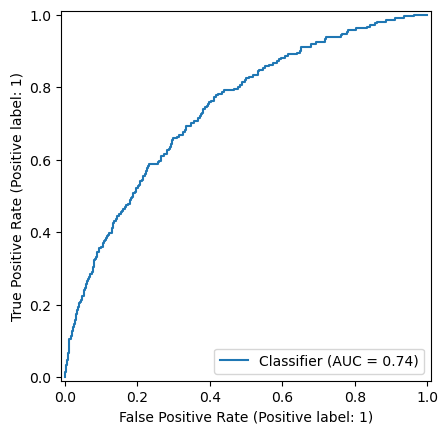

In [156]:
RocCurveDisplay.from_predictions(y_true, y_predict_proba)

In [157]:
probs = pd.DataFrame({
    'y_true' : y_true,
    'y_predict_proba' : y_predict_proba
})

probs = (probs
         .reset_index(drop = True)
         .reset_index(drop = False)
         .sort_values(by = 'index')
        )

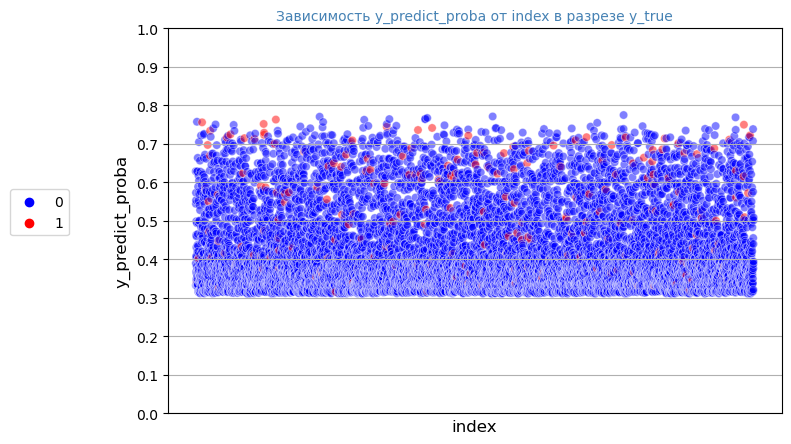

In [159]:
my_scatters(probs,
            x = 'index', 
            y = 'y_predict_proba', 
            y_ticks = np.arange(0, 1.1, 0.1),
            hues = ['y_true'], 
            palette = ['Blue', 'Red'], 
            alpha = 0.5, 
            figsize = (15,5))

C:\Users\egork\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


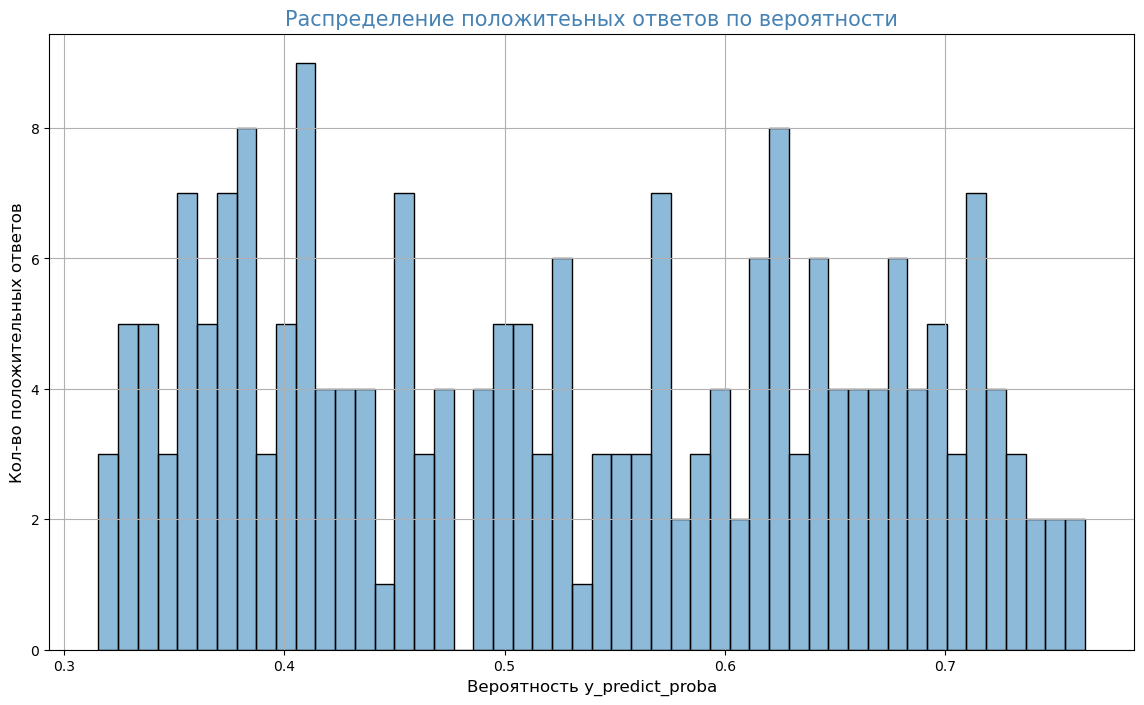

In [161]:
my_hist(probs[probs['y_true'] == 1],
        x = 'y_predict_proba', 
        bins = 50, 
        title = 'Распределение положитеьных ответов по вероятности', 
        xlabel = 'Вероятность y_predict_proba',
        ylabel = 'Кол-во положительных ответов',
        xticks = np.arange(0.3, 0.8, 0.1))

Некоторые классификаторы, такие как SVM или Random Forest, не всегда предсказывают хорошо откалиброванные вероятности. Плюс, модель может быть неуверена в предсказаниях, поэтому пытается поставить вероятность ближе к 0.5

In [162]:
thresholds = np.linspace(0.3, 0.8, 100)  # Пороги от 0 до 1 с шагом
precisions = []
recalls = []
accuracies = []

for threshold in thresholds:
    y_predict_ = [1 if prob >= threshold else 0 for prob in y_predict_proba]
    pr = precision_score(y_true, y_predict_)
    rc = recall_score(y_true, y_predict_)
    correct_predictions = sum([1 for true, pred in zip(y_true, y_predict_) if true == pred])
    total_predictions = len(y_true)
    acc = correct_predictions / total_predictions
    precisions.append(pr)
    recalls.append(rc)
    accuracies.append(acc)

C:\Users\egork\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\egork\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\egork\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\egork\anaconda3\Lib\site-packages\sklearn\metrics\_clas

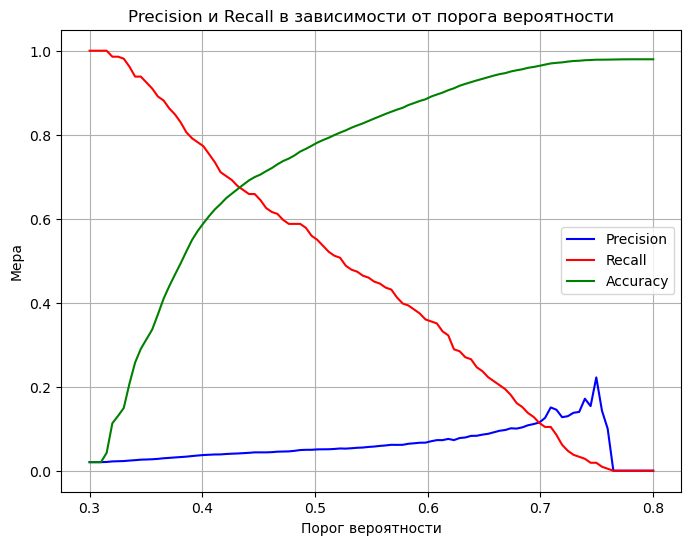

In [163]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', color='b')
plt.plot(thresholds, recalls, label='Recall', color='r')
plt.plot(thresholds, accuracies, label='Accuracy', color='g')
plt.xlabel('Порог вероятности')
plt.ylabel('Мера')
plt.title('Precision и Recall в зависимости от порога вероятности')
plt.grid()
plt.legend()
plt.show()

По графику зависимости от порога вероятности видно, что наклон Precision почти горизонтальный. Т.е. сдвиг порога на Precision мало влияет. А вот Recall можно заметно увеличить если сдвигать порог вероятности в меньшую сторону. По графику Accuracy видно, что если сдвигать порог до 0.43, то Accuracy не слишком сильно падает, а если дальше - то там наклон графика Accuracy становится крутым. Поэтому можно сдвинуть порог до 0.43.

In [164]:
pr = precision_score(y_true, y_predict)
rc = recall_score(y_true, y_predict)
correct_predictions = sum([1 for true, pred in zip(y_true, y_predict) if true == pred])
total_predictions = len(y_true)
acc = correct_predictions / total_predictions

In [165]:
y_predict_43 = [1 if prob >= 0.43 else 0 for prob in y_predict_proba]
cm_43 = confusion_matrix(y_true, y_predict_43)
cm_43 = pd.DataFrame(cm_43)
pr_43 = precision_score(y_true, y_predict_43)
rc_43 = recall_score(y_true, y_predict_43)
correct_predictions_43 = sum([1 for true, pred in zip(y_true, y_predict_43) if true == pred])
total_predictions = len(y_true)
acc_43 = correct_predictions_43 / total_predictions

In [167]:
display(cm)
display(f'Метрика Precsion для порога 0.5: {pr:.3f}')
display(f'Метрика Recall  для порога 0.5: {rc:.3f}')
display(f'Метрика Accuracy  для порога 0.5: {acc:.3f}')
display(cm_43)
display(f'Метрика Precsion для порога 0.43: {pr_43:.3f}')
display(f'Метрика Recall для порога 0.43: {rc_43:.3f}')
display(f'Метрика Accuracy  для порога 0.43: {acc_43:.3f}')

,0,1
0,7934,2201
1,94,117


'Метрика Precsion для порога 0.5: 0.050'

'Метрика Recall  для порога 0.5: 0.555'

'Метрика Accuracy  для порога 0.5: 0.778'

,0,1
0,6765,3370
1,66,145


'Метрика Precsion для порога 0.43: 0.041'

'Метрика Recall для порога 0.43: 0.687'

'Метрика Accuracy  для порога 0.43: 0.668'

<span style="color: red;">Посоветуй плиз, в какую сторону еще можно капнуть чтобы улучшить предсказания? Модель так себе, хочется улучшить, но я пока в тупике, увы((</span>

### 4.3. Анализ важности признаков

Посмотрим в какой степени повлиял на целевой каждый из признаков

In [168]:
features = X_test_list[best_set_number].columns
feature_importances = (pd.DataFrame(
    {
        'Feature': features,
        'Importance' :  model.named_steps['models'].feature_importances_
    }
)
                       .sort_values(by = 'Importance', ascending = False)
                      )

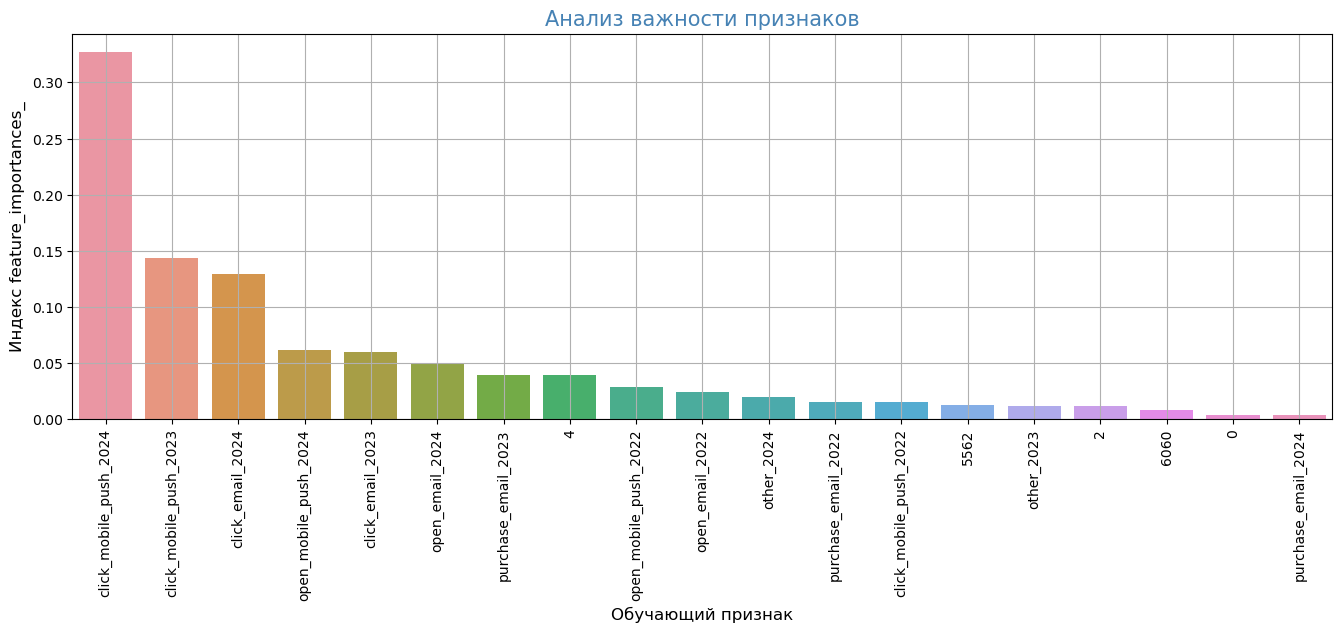

In [169]:
#feature_importances.head(20)
my_plot(feature_importances, 
        title  = 'Анализ важности признаков', 
        xlabel = 'Обучающий признак',
        ylabel = 'Индекс feature_importances_',
        patches = False,
        labelrotation = 90
       )

Видим, что наиболее определяющими признаками того, совершит ли покупку клиент, являются, в порядке убывания важности:

1) Кол-во кликов на push-уведомление с рекламной акцией в текущем году и в меньшей степени - в прошедшем
2) Кол-во кликов писем с рекламными предложениями в текущем году
3) Кол-во открытий рекламных предложений в push-уведомлениях в текущем году
4) Кол-во открытий писем с рекламными предложениями в текущем и прошедщем годах
5) Кол-во покупок товаров с группой категорий 4 

## 5. Вывод

В ходе выполнения проекта была достигнута основная цель - разработана модель для предсказания вероятности покупки клиентами интернет-магазина в ближайшее время.

В процессе работы были решены следующие ключевые задачи


Проведен глубокий анализ и предобрабоданныхн

ых:
Выполнена очистка датасетов от дубликатов и аномалий
Созданы новые информативные признаки (временные метки, агрегатные показатели)
Проведен корреляционный анализ и отбор наиболее значимых пр

 данных
Разработана и оптимизирована модель класс
ификации:
Исследованы различные алгоритмы (случайные деревья, LGBM,, среди них выбрана модель случайных деревьев CatBoost)
Проведена настройка гиперпараметров
Выполнена калибровка модели под спец
  ифику задачи
Достигнуты следующие метрики качества:
ROC_AUC: 0.7441recision: 06740
Recall: 0.555
Accuracy (при оптимальном пороге 0.43): 0.668
Анализ важности признаков показал, что ключевыми факторами, влияющими на вероятность покупки, являются:

Активность клиента в push-уведомлениях с рекламными акциями
Количество кликов по рекламным письмам
Частота открытий рекламных предложений в push-уведомлениях
История открытий рекламных писем
Ист
ория предыдущих покупок
Практическая значимость проекта заключается в создании инструмента для:

Оптимизации маркетинговых кампаний
Эффективного распределения рекламных бюджетов
Выявления наиболее перспективных клиентов

Планирования будущих продаж
Перспективы дальнейшего развития проекта включают:

Интеграцию модели в систему автоматизации маркетинга
Расширение набора признаков за счет дополнительных данных о клиентах
Регулярное обновй для оптимизации Precision и Recall
Таким образом, разработанная модель может стать эффективным инструментом для повышения эффективности маркетинговых кампаний и увеличения конверсии интернет-магазина.

